# Hallucination Score Analysis

In this notebook, the hallucination scores of the methods are analyzed.

In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    precision_recall_curve, 
    f1_score, 
    precision_score, 
    recall_score, 
    accuracy_score
)
from sklearn.preprocessing import binarize
from scipy.stats import chi2_contingency
import time
from IPython.display import display, Markdown

## Functions

In [2]:
# LOADING
# load the dataframes and durations from the results folder
def load_dataframes(f):
    dataset_name = f.split("__")[0].split("_")[-4]
    model_name = f.split(dataset_name)[0].split("\\")[-1] +"_"+ f.split("__")[-1].split(".")[0]
    df = pd.read_csv(f)
    df.drop([col for col in df.columns if "answer" in col or "prompt" in col], axis=1, inplace=True)
    durations = f.split(dataset_name)[0] + "durations.csv"
    durations_df = pd.read_csv(durations) if len(glob.glob(durations)) > 0 else None
    return {"dataset_name": dataset_name, "model": model_name, "df": df, "durations": durations_df}

# __________________________

# PREPROCESSING
# fix json errors in the column lbhd_score
def fix_json_errors(df):
    count = 0
    for index, row in df.iterrows():
        json_str = row['lbhd_score'].replace("'", "\"")
        start_time = time.time()
        dropped_row_err_count = 0
        fixed_rows = 0
        while True:
            try:
                # Attempt to parse the JSON string
                json.loads(json_str)
                break  # Exit the loop if no error
            except json.JSONDecodeError as e:
                # If there's a JSONDecodeError, extract the position of the error
                error_pos = e.pos
                # Add a backslash to the string in front of the error to escape the character
                json_str = json_str[:error_pos - 1] + "\\" + json_str[error_pos - 1:]
                # Replace the JSON string in the DataFrame with the corrected one
                df.at[index, 'lbhd_score'] = json_str
                count += 1
            # Check if 2 seconds have passed
            if time.time() - start_time > 2:
                print(f"Fixing row {index} took too long. Dropping this row.")
                df = df.drop(index)
                dropped_row_err_count += count
                break
    print(f"Fixed {count - dropped_row_err_count} JSON errors in the 'lbhd_score' column.")
    return df

# normalize the columns
def normalize_column(column):
    # Apply Min-Max normalization
    column = (column - column.min()) / (column.max() - column.min())
    # rescale to [0, 1] range (from [-1, 1] range)
    column = (column + 1) / 2
    return column

# process the lbhd_score column
def process_lbhd_scores(df):
    # Initialize new columns with default values
    df['lbhd_sent_avg'] = 0.0
    df['lbhd_sent_min'] = 0.0
    df['lbhd_sent_normalized_product'] = 0.0
    df['lbhd_concept_avg'] = 0.0
    df['lbhd_concept_min'] = 0.0
    df['lbhd_concept_normalized_product'] = 0.0
    # Iterate over each row to process the 'lbhd_score' column
    for index, row in df.iterrows():
        # Parse the string representation of the dictionary into an actual dictionary
        lbhd_score = json.loads(row['lbhd_score'].replace("'", "\""))        
        # Extract the low-level scores
        df.at[index, 'lbhd_sent_avg'] = lbhd_score['avg']
        df.at[index, 'lbhd_sent_min'] = lbhd_score['min']
        df.at[index, 'lbhd_sent_normalized_product'] = lbhd_score['normalized_product']        
        # Aggregate the concept-level scores
        concept_avgs = [concept[next(iter(concept))]['avg'] for concept in lbhd_score['concepts']]
        concept_mins = [concept[next(iter(concept))]['min'] for concept in lbhd_score['concepts']]
        concept_norm_prods = [concept[next(iter(concept))]['normalized_product'] for concept in lbhd_score['concepts']]        
        df.at[index, 'lbhd_concept_avg'] = np.mean(concept_avgs)
        df.at[index, 'lbhd_concept_min'] = np.min(concept_mins)
        def normalized_product(probabilities):
            adjusted_probs = [max(p, 1e-30) for p in probabilities]
            log_probs = np.log(adjusted_probs)
            score = np.exp(np.sum(log_probs) / len(adjusted_probs))
            return score
        df.at[index, 'lbhd_concept_normalized_product'] = normalized_product(concept_norm_prods)
    # Remove the 'lbhd_score' column
    df.drop('lbhd_score', axis=1, inplace=True)
    # Normalize the new columns
    df['lbhd_sent_avg'] = normalize_column(df['lbhd_sent_avg'])
    df['lbhd_sent_min'] = normalize_column(df['lbhd_sent_min'])
    df['lbhd_sent_normalized_product'] = normalize_column(df['lbhd_sent_normalized_product'])
    df['lbhd_concept_avg'] = normalize_column(df['lbhd_concept_avg'])
    df['lbhd_concept_min'] = normalize_column(df['lbhd_concept_min'])
    df['lbhd_concept_normalized_product'] = normalize_column(df['lbhd_concept_normalized_product'])
    # reverse calculation of: linear_probs = [(prob + 1) / 2 for prob in linear_probs]
    for col in df.columns:
        if "lbhd" in col:
            df[col] = (df[col] * 2) - 1
            #  invert the values 
            df[col] = df[col] * -1 + 1
    return df

# process the lm_v_lm_score column
def process_lm_v_lm_scores(df):
    # Unsure (0.5) is considered as True (Hallucination)
    df['lm_v_lm_score'] = df['lm_v_lm_score'].apply(lambda x: bool(x) if x != 0.5 else True)
    return df

# Remove rows with errors
def remove_err_rows(df):
    n_rows = len(df)
    print(f"Initial rows: {n_rows}")
    df = df.dropna()
    # if objects, means its a string representation of a dictionary
    for col in df.columns:
        if df[col].dtype == "object":
            # remove if 'error' is first key
            df = df[~df[col].str.contains("error")]
            if len(df) < n_rows:
                print(f"Removed {n_rows - len(df)} rows with errors in column {col}")
            n_rows = len(df)  # update n_rows for the next iteration
        elif df[col].dtype == "float64":
            # remove if -1
            df = df[df[col] != -1]
            if len(df) < n_rows:
                print(f"Removed {n_rows - len(df)} rows with errors in column {col}")
            n_rows = len(df)  # update initial_rows for the next iteration
    print(f"Final rows: {n_rows}\n")
    return df

# preprocess datatypes
def preprocess_datatypes(df):
    # Convert 'ground_truth' to boolean
    df['ground_truth'] = df['ground_truth'].astype(bool)
    df['fleek_score'] = df['fleek_score'].astype(bool)
    return df

# rescale numerical columns to [0, 1]
def rescale_numerical_columns(df):
    for col in df.columns:
        if df[col].dtype == "float64":
            df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

# Define a function to process each dataframe
def process_dataframe(df):
    # Remove rows with errors
    df = remove_err_rows(df)
    # Fix JSON errors
    df = fix_json_errors(df)
    # Process LBHD scores
    df = process_lbhd_scores(df)
    # Process LM vs. LM scores
    df = process_lm_v_lm_scores(df)
    # Preprocess datatypes
    df = preprocess_datatypes(df)
    # Rescale numerical columns
    df = rescale_numerical_columns(df)
    return df

# __________________________

# EVALUATION
# getting F1 optimal thresholds for each continuous column
def get_optimal_thresholds(df):
    thresholds = {}
    for col in df.columns:
        if df[col].dtype == "float64":
            y_true = df['ground_truth']
            y_pred = df[col]
            precision, recall, thresholds[col] = precision_recall_curve(y_true, y_pred)
    return thresholds

# calculate the metrics for each column (AUC-ROC, AUC-PR, weighted precision, weighted recall, weighted F1)
def calculate_metrics(df, positive_class=True):
    metrics = {}
    ground_truth = df['ground_truth'].values

    for column in df.columns:
        if column == 'ground_truth':
            continue
        score = df[column].values
        
        # Check if the column is boolean
        if np.issubdtype(score.dtype, np.bool_):
            # Handle boolean scores directly
            binarized_score = score  # No need to binarize
            auc_roc = roc_auc_score(ground_truth, score)
            auc_pr = average_precision_score(ground_truth, score)
        else:
            # Calculate AUC-ROC and AUC-PR
            auc_roc = roc_auc_score(ground_truth, score)
            auc_pr = average_precision_score(ground_truth, score)
            
            # Use precision_recall_curve to find an optimal threshold
            precision, recall, thresholds = precision_recall_curve(ground_truth, score, pos_label=positive_class)
            # Example: Choose a threshold (this could be based on a desired recall or precision level)
            # For demonstration, let's maximize F1 (default behavior in the original function)
            if thresholds.size > 0:
                f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)
                best_idx = np.argmax(f1_scores)
                threshold = thresholds[best_idx]
                binarized_score = binarize(score.reshape(1, -1), threshold=threshold).flatten()
            else:
                print(f"No optimal threshold found for column {column} with score {score}")
                binarized_score = np.zeros_like(score, dtype=bool)
        
        # Calculate metrics using sklearn's average='weighted' to handle imbalance
        # precision_weighted = precision_score(ground_truth, binarized_score, average='weighted')
        # recall_weighted = recall_score(ground_truth, binarized_score, average='weighted')
        # f1_weighted = f1_score(ground_truth, binarized_score, average='weighted')
        # Calculate metrics using sklearn's average='binary' to handle imbalance
        precision_weighted = precision_score(ground_truth, binarized_score, average='binary', pos_label=positive_class)
        recall_weighted = recall_score(ground_truth, binarized_score, average='binary', pos_label=positive_class)
        f1_weighted = f1_score(ground_truth, binarized_score, average='binary', pos_label=positive_class)
        accuracy = accuracy_score(ground_truth, binarized_score)  # Calculate accuracy
        
        metrics[column] = {"AUC-ROC": auc_roc, "AUC-PR": auc_pr, "Precision ": precision_weighted, "Recall ": recall_weighted, "F1": f1_weighted, "Accuracy": accuracy}
    return metrics


# __________________________

# VISUALIZATION
# plot the correlation matrix
def plot_correlation_matrix(df, model_name, dataset_name, method):
    # Ensure 'ground_truth' is the last column
    columns = [col for col in df.columns if col != 'ground_truth'] + ['ground_truth']
    df = df[columns]
    # Compute the correlation matrix
    corr = df.corr(method=method)
    # Identify the 3 strongest correlations with 'ground_truth' by absolute value, excluding itself
    strongest_corr = corr['ground_truth'].drop('ground_truth').abs().nlargest(3).index.tolist()
    fig, ax = plt.subplots(figsize=(7, 5))  # 11, 6
    cmap = "YlGnBu"
    # Draw the heatmap with the correct aspect ratio
    sns.heatmap(corr.loc[['ground_truth']], cmap=cmap, vmax=1, vmin=0, center=0.5,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot=True, fmt=".2f", annot_kws={"size": 7})
    # Highlight the columns of the 3 strongest correlations
    for strong_corr in strongest_corr:
        ax.add_patch(Rectangle((df.columns.get_loc(strong_corr), 0), 1, 1, fill=False, edgecolor='red', lw=3))
    ax.set_xticks(np.arange(len(corr.columns)) + .5)
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticklabels(['ground_truth'])
    # Set title with model and dataset names
    dataset_name = "Natural Questions" if dataset_name == "nqopen" else "XSum" if dataset_name == "xsum" else dataset_name
    plt.title(f'{method.capitalize()} Correlation Matrix\nfor {model_name}\non dataset "{dataset_name}"', fontsize=16, pad=20)
    # Adjust layout to fit everything
    plt.tight_layout()
    # save the plot
    if not os.path.exists("results/visualizations"):
        os.makedirs("results/visualizations")
    plt.savefig(f"results/visualizations/correlation_matrix__{model_name}__{dataset_name}__{method}.png", bbox_inches="tight")
    # Display the plot
    plt.show()

# plot the metrics heatmap
def plot_metrics(metrics, model_name, dataset_name, positive_class):
    # Convert metrics to DataFrame and transpose
    metrics_df = pd.DataFrame(metrics).T
    # Create a heatmap
    plt.figure(figsize=(8, 5))
    sns.heatmap(metrics_df, annot=True, cmap='YlGnBu', vmin=0, vmax=1)
    positive_class = True if positive_class in [True, 'positive'] else False
    label = "Hallucination" if positive_class == True else "Factual Answer"
    dataset_name = "Natural Questions" if dataset_name == "nqopen" else "XSum" if dataset_name == "xsum" else dataset_name
    plt.title(f'Metrics for {model_name}\non dataset "{dataset_name}"\nfor class {positive_class} ({label})', fontsize=16, pad=20)
    # Rotate x-ticks by 45 degrees
    plt.xticks(rotation=45)
    # save the plot
    if not os.path.exists("results/visualizations"):
        os.makedirs("results/visualizations")
    plt.savefig(f"results/visualizations/metrics_heatmap__{model_name}__{dataset_name}__{positive_class}.png", bbox_inches="tight")
    plt.show()

# violin plots and anova for numerical columns
def violin_plots_and_anova(df):
    # Ensure 'ground_truth' is the last column
    columns = [col for col in df.columns if col != 'ground_truth'] + ['ground_truth']
    df = df[columns]
    # Create a new DataFrame to store the ANOVA results
    anova_results = pd.DataFrame(columns=['feature', 'f_value', 'p_value'])
    # Iterate over each feature to perform the ANOVA test
    for feature in df.columns[:-1]:
        # Perform the ANOVA test
        f_value, p_value = chi2_contingency(pd.crosstab(df[feature], df['ground_truth']))[:2]
        # Append the results to the DataFrame
        anova_results.loc[len(anova_results)] = {'feature': feature, 'f_value': f_value, 'p_value': p_value}
    # Sort the results by p-value
    anova_results = anova_results.sort_values(by='p_value')
    # Display the ANOVA results in a simple formatted table
    display(anova_results)
    # Plot the violin plots for numerical columns only
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numerical_cols:
        # Add some random noise to the data
        df[col] = df[col] + np.random.normal(0, 0.1, size=len(df))

        fig, ax = plt.subplots(figsize=(10, 6))
        # Use a custom color palette
        sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')
        # sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu'[::-1])
        sns.swarmplot(x=df['ground_truth'], y=df[col], color="white", ax=ax, size=5, alpha=0.5)
        ax.set_title(f'Violin Plots for {col}')
        plt.tight_layout()
        plt.show()
    
# plot the durations distribution
def plot_durations(durations_df):
    mean_durations = durations_df.mean()
    display(mean_durations.round(2))
    # plot distributions
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))  # Adjust the figure size to better fit horizontal boxplot
    sns.boxplot(durations_df, ax=ax, palette="YlGnBu", orient='h')  # Add orient='h' to make the boxplot horizontal
    ax.set_title('Durations Distribution')
    ax.set_xlabel('Detection Time (s)')  # Add x label
    ax.set_ylabel('Detection Method')  # Add y label
    plt.tight_layout()
    # save the plot
    if not os.path.exists("results/visualizations"):
        os.makedirs("results/visualizations")
    plt.savefig(f"results/visualizations/durations_distribution.png", bbox_inches="tight")
    plt.show()

# __________________________

# MAIN
# Define a function to calculate and return metrics for each dataframe
def evaluate_dataframe(df):
    # Calculate metrics for the positive class (hallucinated answer prediction)
    metrics_positive = calculate_metrics(df, positive_class=True)
    # Calculate metrics for the negative class (factual answer prediction)
    metrics_negative = calculate_metrics(df, positive_class=False)
    return metrics_positive, metrics_negative

## Loading the scores

In [3]:
# load datasets
# find all csvs with scores and ground truths
files = glob.glob("results/*with_ground_truths*.csv")

# load all csvs into a list of dataframes
datasets = [load_dataframes(f) for f in files]

print(f"Found {len(datasets)} CSVs with scores and ground truths for analysis:\n")
for dataset in datasets:
    print(f"Dataset: {dataset['dataset_name']}")
    print(f"LLM: {dataset['model']}")
    print(f"Shape: {dataset['df'].shape}\n")

Found 6 CSVs with scores and ground truths for analysis:

Dataset: nqopen
LLM: openai__gpt-3-5-turbo
Shape: (80, 6)

Dataset: xsum
LLM: openai__gpt-3-5-turbo
Shape: (80, 6)

Dataset: nqopen
LLM: togetherai_2__mistralai_Mistral-7B-Instruct-v0-1
Shape: (80, 6)

Dataset: xsum
LLM: togetherai_2__mistralai_Mistral-7B-Instruct-v0-1
Shape: (80, 6)

Dataset: nqopen
LLM: togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1
Shape: (80, 6)

Dataset: xsum
LLM: togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1
Shape: (80, 6)



# Running the Analysis

### Analysis of detection speeds

lbhd                77.30
lm_v_lm           1015.06
fleek             1000.83
selfcheck_nli      143.48
selfcheck_bert     464.29
dtype: float64

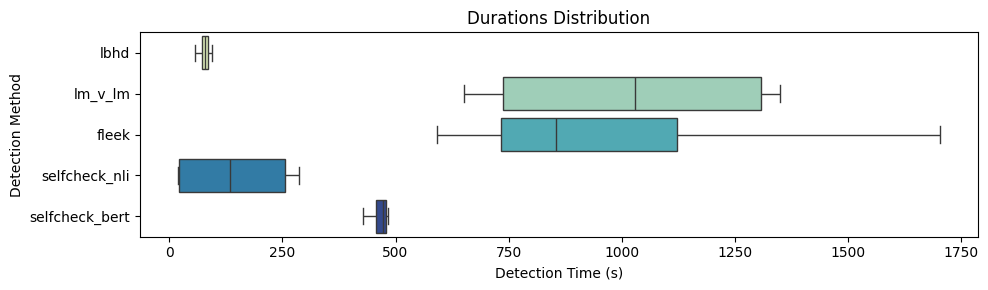

In [4]:
# analyzing the durations (s) per method
durations = pd.concat([dataset['durations'] for dataset in datasets if dataset['durations'] is not None])
# means and boxplots of durations in seconds
plot_durations(durations)

### Preprocessing and metric calculation

In [5]:
# structure to hold the metrics
all_metrics = {}
all_processed_dfs = []

# Process and evaluate all datasets
for dataset in datasets:
    model_name = dataset['model']
    dataset_name = dataset['dataset_name']
    print(f"\nProcessing {model_name} on {dataset_name}")

    # Process the dataframe
    processed_df = process_dataframe(dataset['df'].copy())
    all_processed_dfs.append((model_name, dataset_name, processed_df))

    # Calculate metrics for both classes
    metrics_positive, metrics_negative = evaluate_dataframe(processed_df)

    # Store metrics in the dictionary
    if model_name not in all_metrics:
        all_metrics[model_name] = {}
    all_metrics[model_name][dataset_name] = {
        'positive': metrics_positive,
        'negative': metrics_negative
    }


Processing openai__gpt-3-5-turbo on nqopen
Initial rows: 80
Removed 7 rows with errors in column fleek_score
Final rows: 73

Fixed 10 JSON errors in the 'lbhd_score' column.

Processing openai__gpt-3-5-turbo on xsum
Initial rows: 80
Removed 50 rows with errors in column fleek_score
Final rows: 30

Fixing row 54 took too long. Dropping this row.
Fixed 29960 JSON errors in the 'lbhd_score' column.

Processing togetherai_2__mistralai_Mistral-7B-Instruct-v0-1 on nqopen
Initial rows: 80
Final rows: 80

Fixed 7 JSON errors in the 'lbhd_score' column.

Processing togetherai_2__mistralai_Mistral-7B-Instruct-v0-1 on xsum
Initial rows: 80
Final rows: 80

Fixed 8 JSON errors in the 'lbhd_score' column.

Processing togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1 on nqopen
Initial rows: 80
Removed 2 rows with errors in column fleek_score
Final rows: 78

Fixed 13 JSON errors in the 'lbhd_score' column.

Processing togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1 on xsum
Initial rows: 80
Final rows

## Across all models and datasets

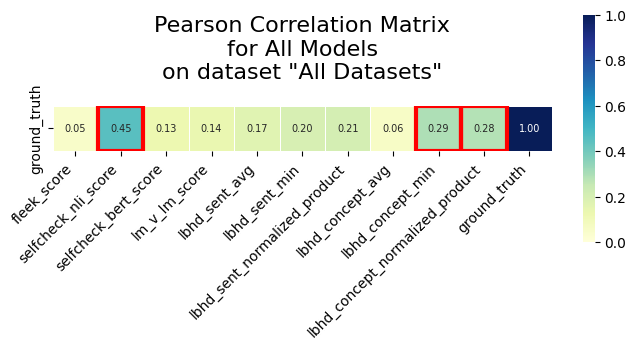

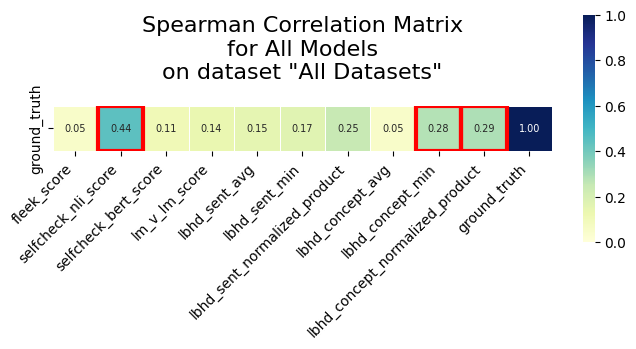

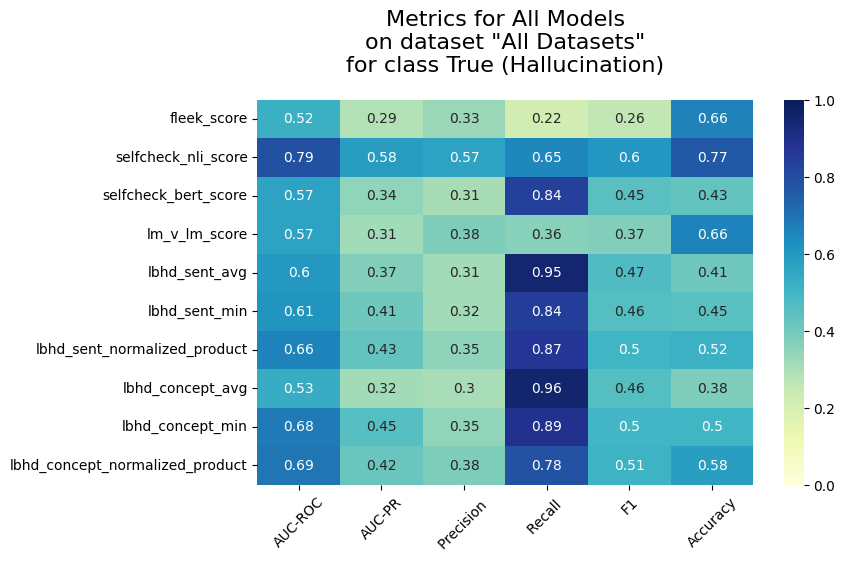

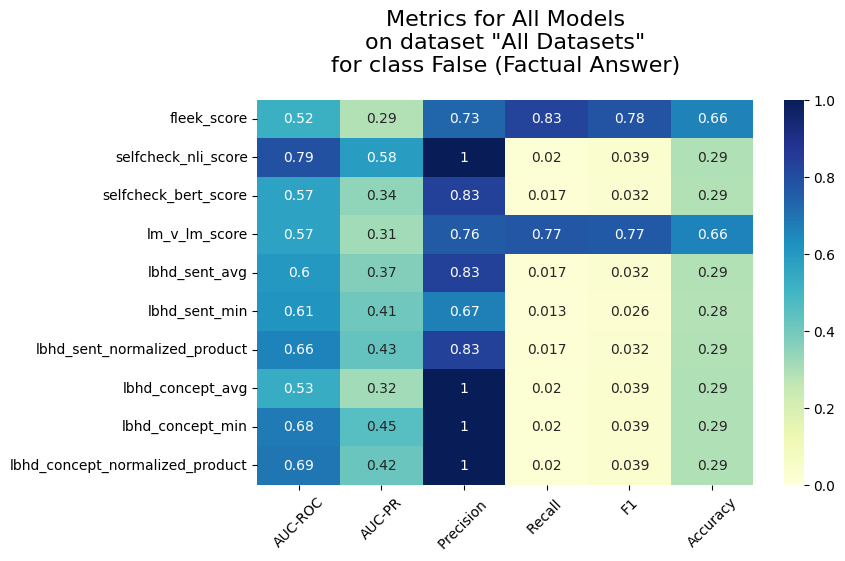

In [6]:
# Combine all processed dataframes into one
all_dfs = pd.concat([df[2] for df in all_processed_dfs], axis=0)
# plot the correlation matrix
plot_correlation_matrix(all_dfs, "All Models", "All Datasets", "pearson")
plot_correlation_matrix(all_dfs, "All Models", "All Datasets", "spearman")
# plot the metrics heatmap
metrics_positive = calculate_metrics(all_dfs, positive_class=True)
metrics_negative = calculate_metrics(all_dfs, positive_class=False)
plot_metrics(metrics_positive, "All Models", "All Datasets", True)
plot_metrics(metrics_negative, "All Models", "All Datasets", False)

## Per task (dataset)

### Natural Questions

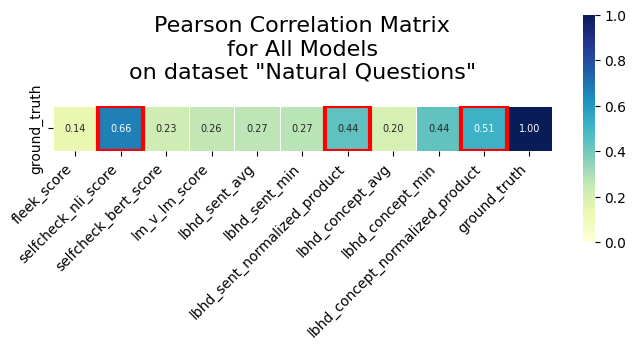

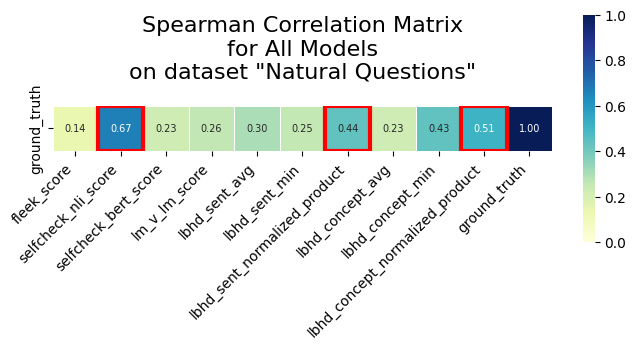

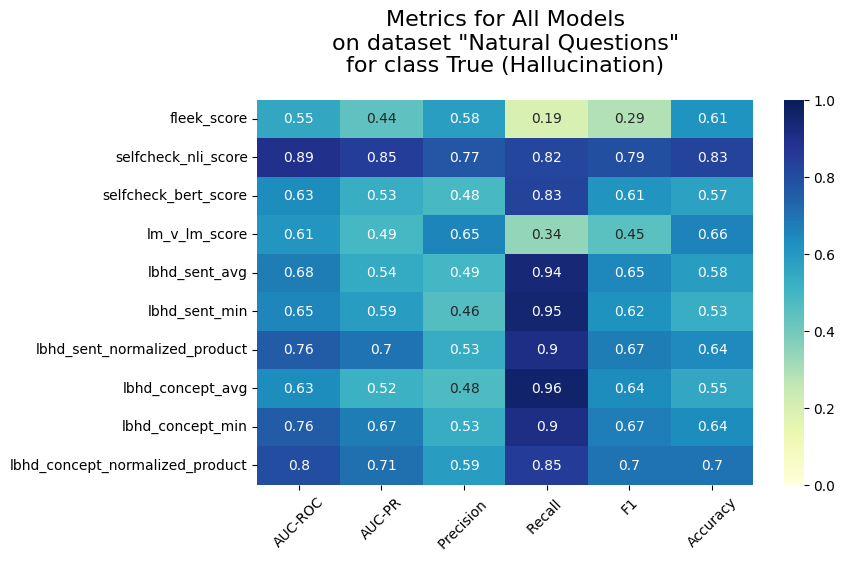

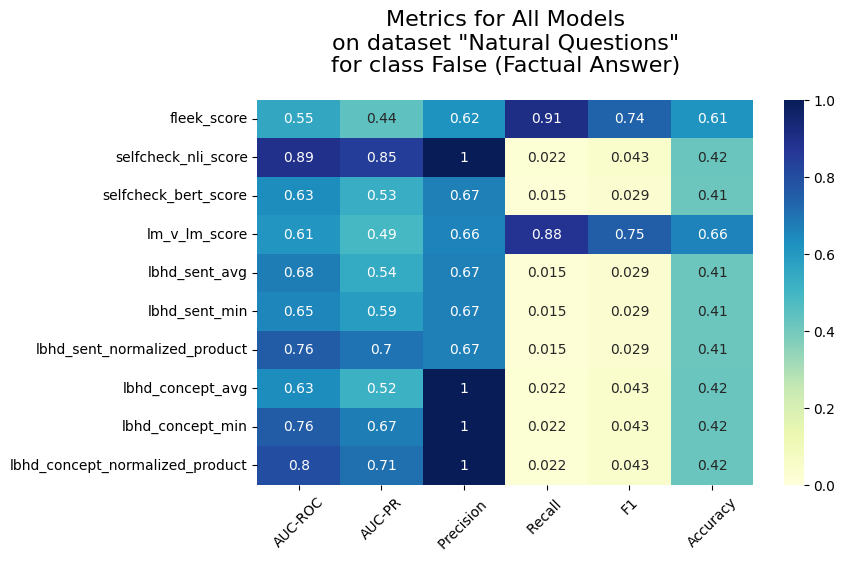

In [7]:
nqopen_dfs = [df[2] for df in all_processed_dfs if df[1] == "nqopen"]
nqopen_dfs = pd.concat(nqopen_dfs, axis=0)
# plot the correlation matrix
plot_correlation_matrix(nqopen_dfs, "All Models", "nqopen", "pearson")
plot_correlation_matrix(nqopen_dfs, "All Models", "nqopen", "spearman")
# plot the metrics heatmap
metrics_positive = calculate_metrics(nqopen_dfs, positive_class=True)
metrics_negative = calculate_metrics(nqopen_dfs, positive_class=False)
plot_metrics(metrics_positive, "All Models", "nqopen", True)
plot_metrics(metrics_negative, "All Models", "nqopen", False)

### XSum

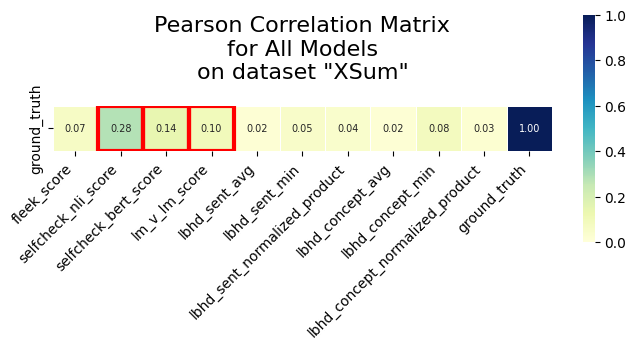

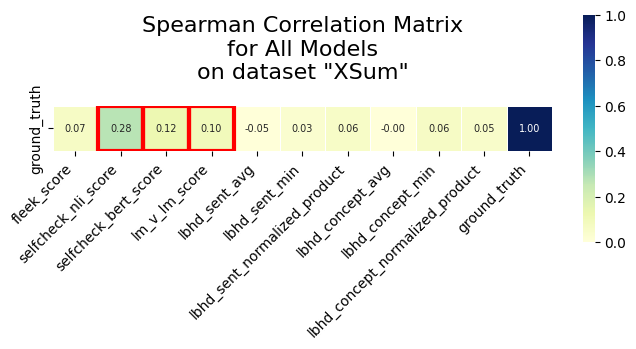

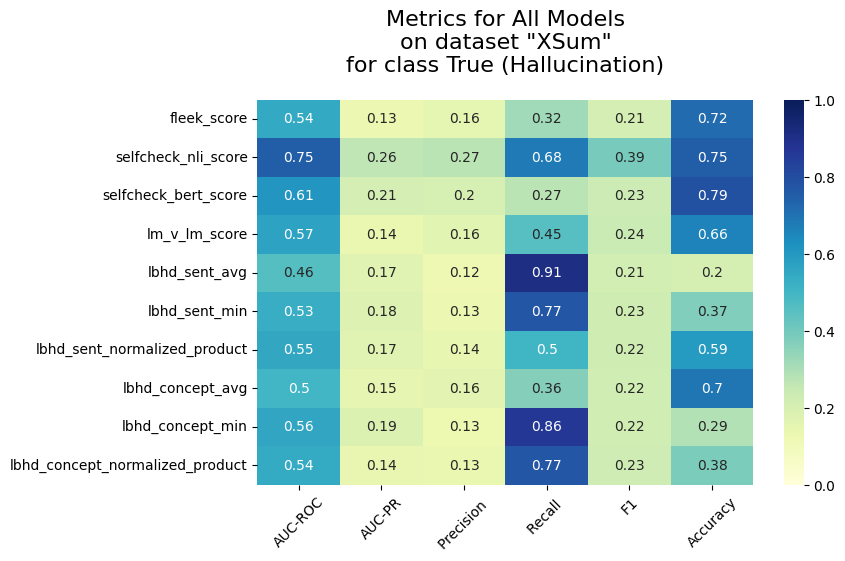

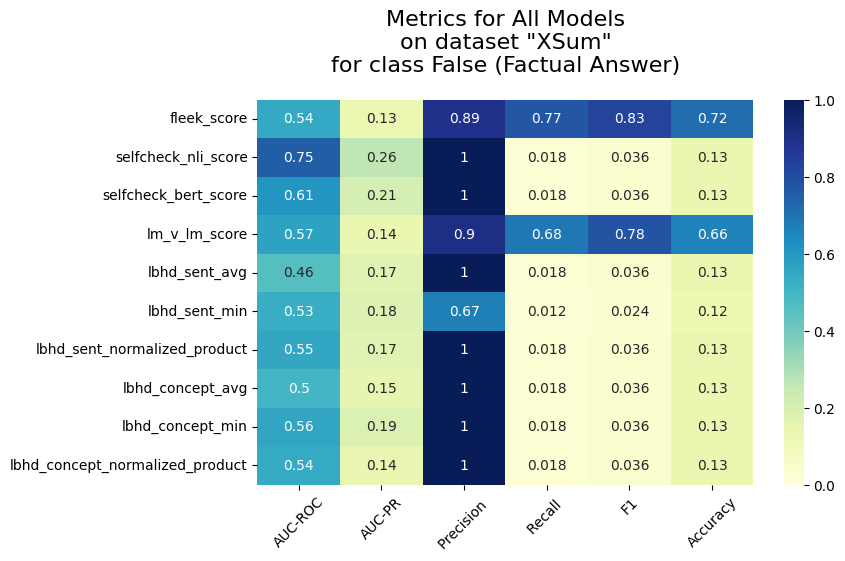

In [8]:
xsun_dfs = [df[2] for df in all_processed_dfs if df[1] == "xsum"]
xsun_dfs = pd.concat(xsun_dfs, axis=0)
# plot the correlation matrix
plot_correlation_matrix(xsun_dfs, "All Models", "xsum", "pearson")
plot_correlation_matrix(xsun_dfs, "All Models", "xsum", "spearman")
# plot the metrics heatmap
metrics_positive = calculate_metrics(xsun_dfs, positive_class=True)
metrics_negative = calculate_metrics(xsun_dfs, positive_class=False)
plot_metrics(metrics_positive, "All Models", "xsum", True)
plot_metrics(metrics_negative, "All Models", "xsum", False)

## Per model and dataset

### Correlation Matrices

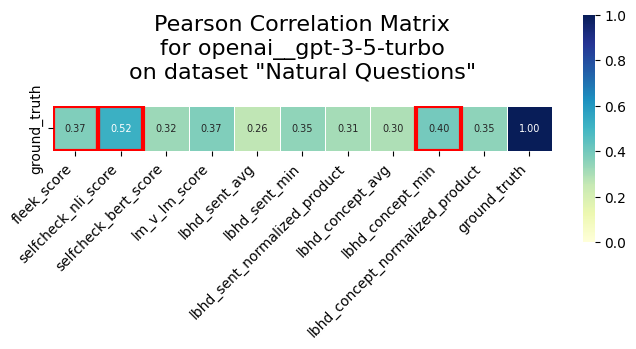

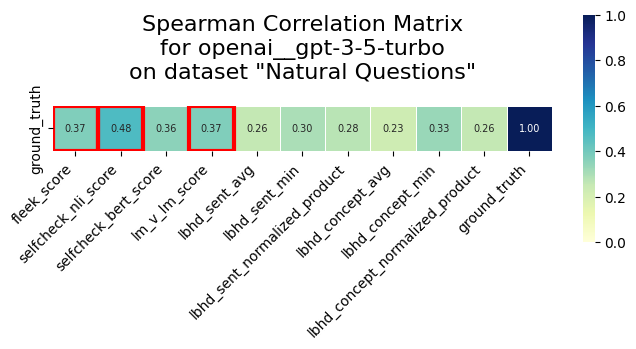

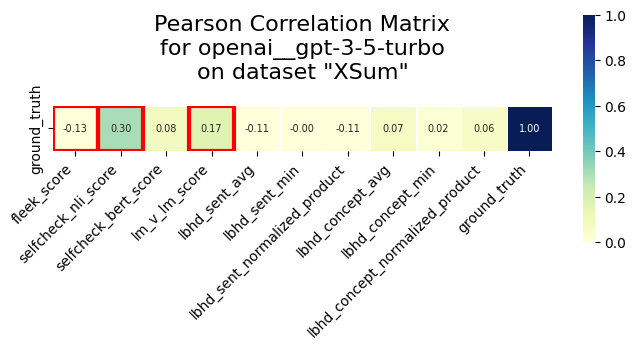

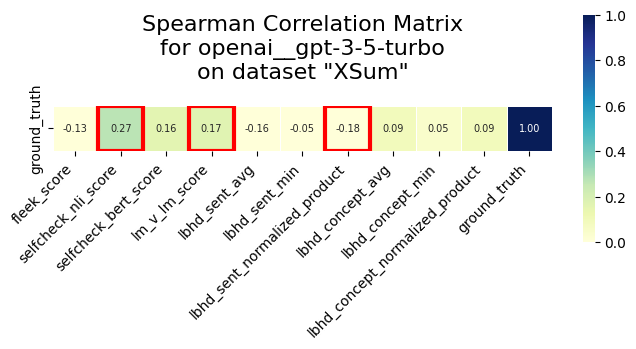

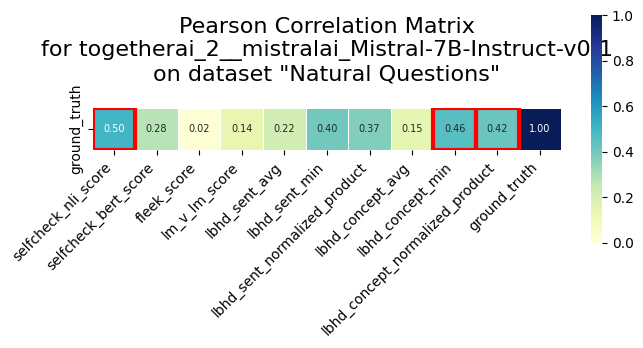

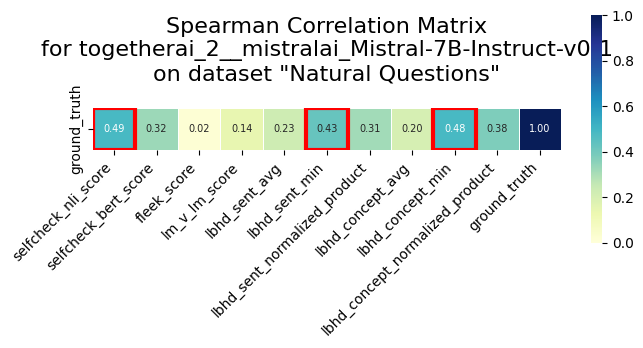

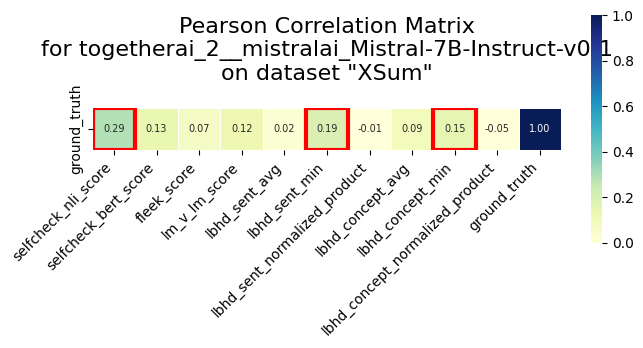

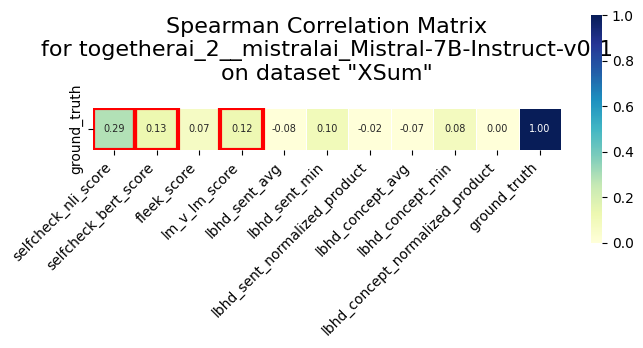

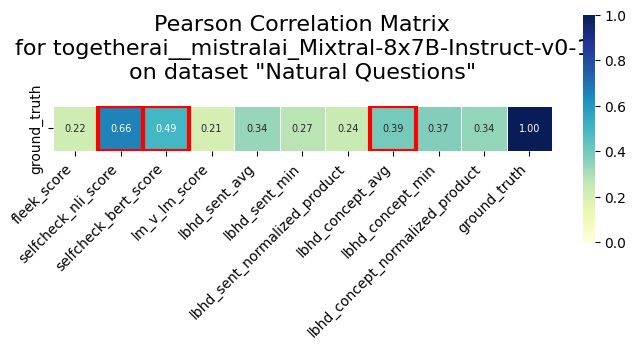

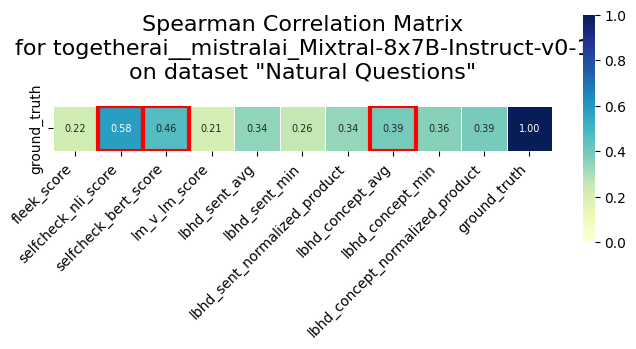

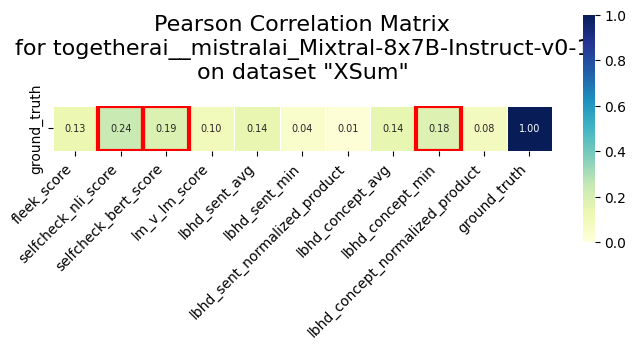

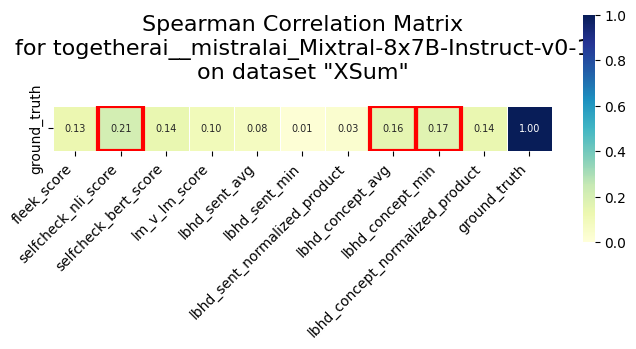

In [9]:

# Plotting correlation matrices for each model and dataset combination
for model_name, dataset_name, processed_df in all_processed_dfs:
    # Plot the Pearson and Spearman correlation matrices
    plot_correlation_matrix(processed_df, model_name, dataset_name, "pearson")
    plot_correlation_matrix(processed_df, model_name, dataset_name, "spearman")

### Metrics

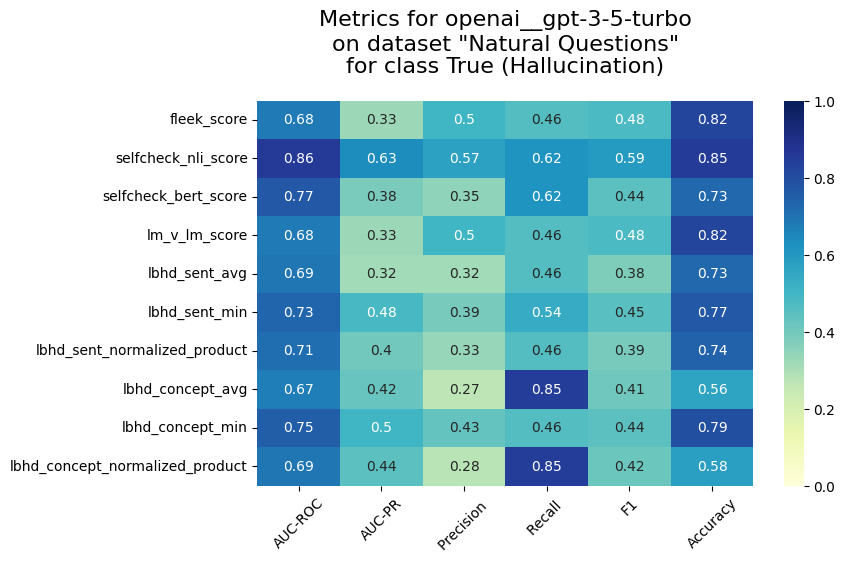

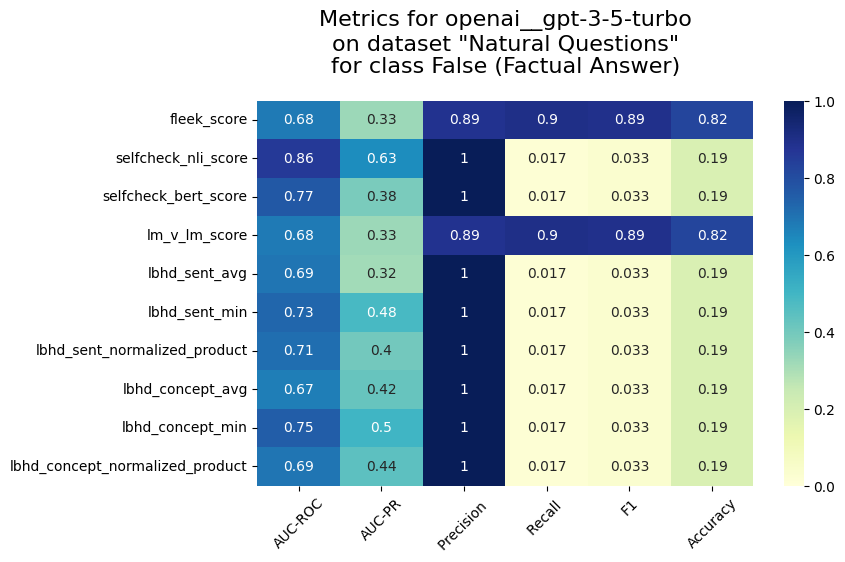

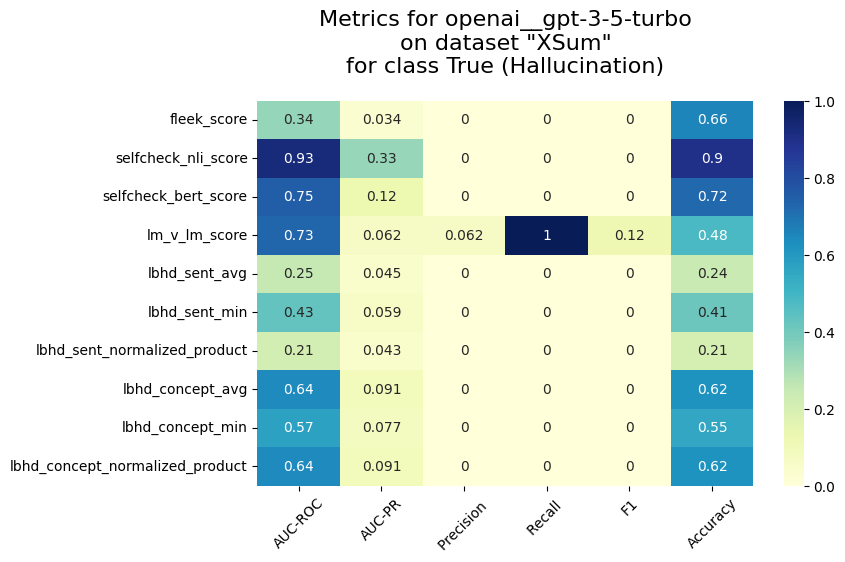

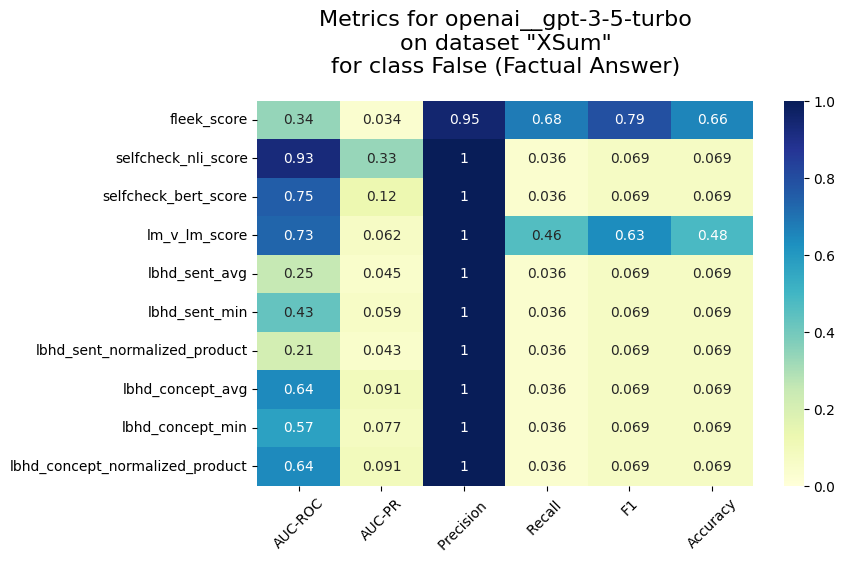

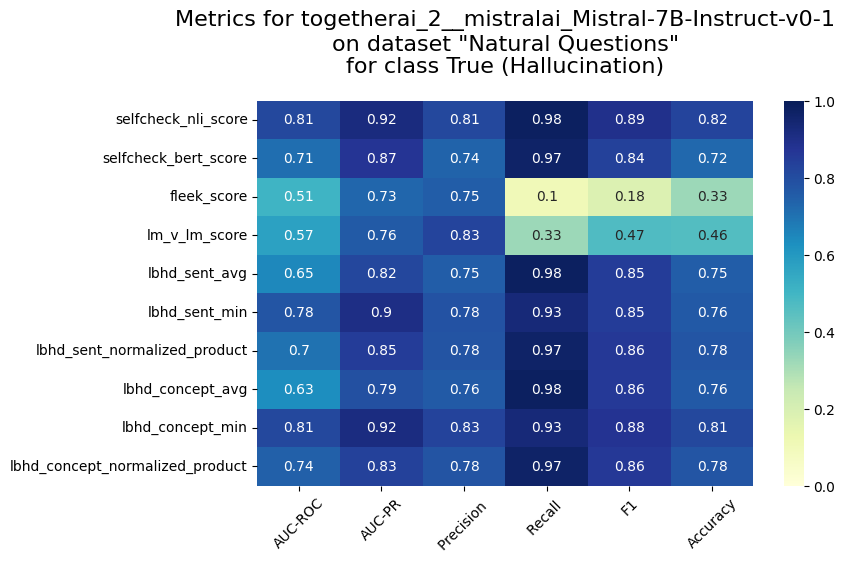

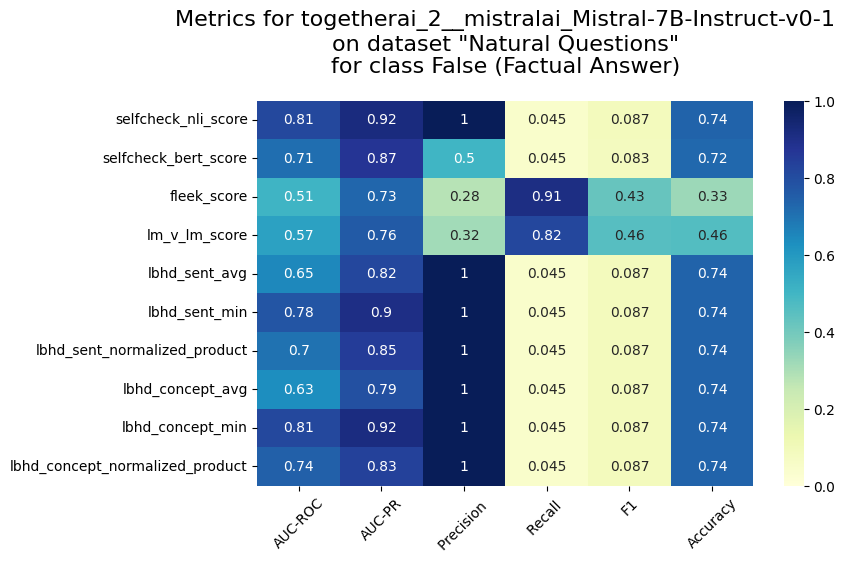

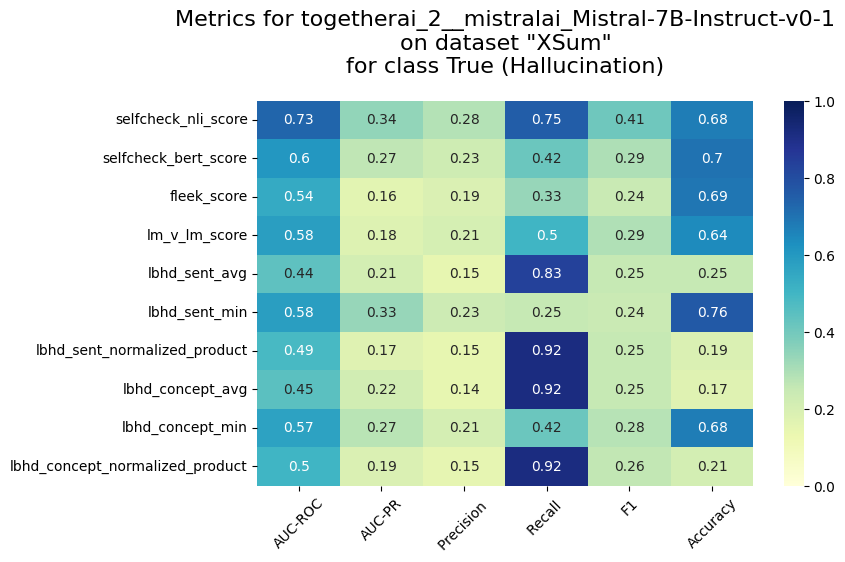

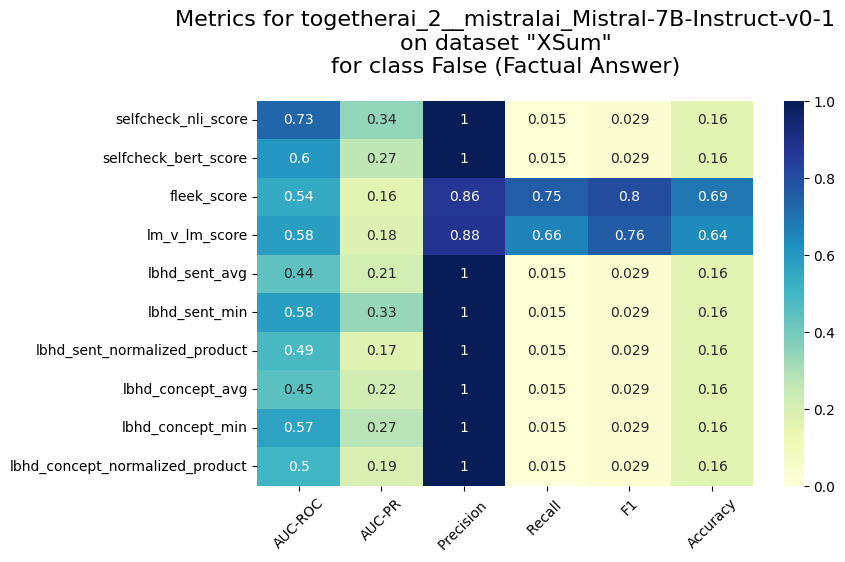

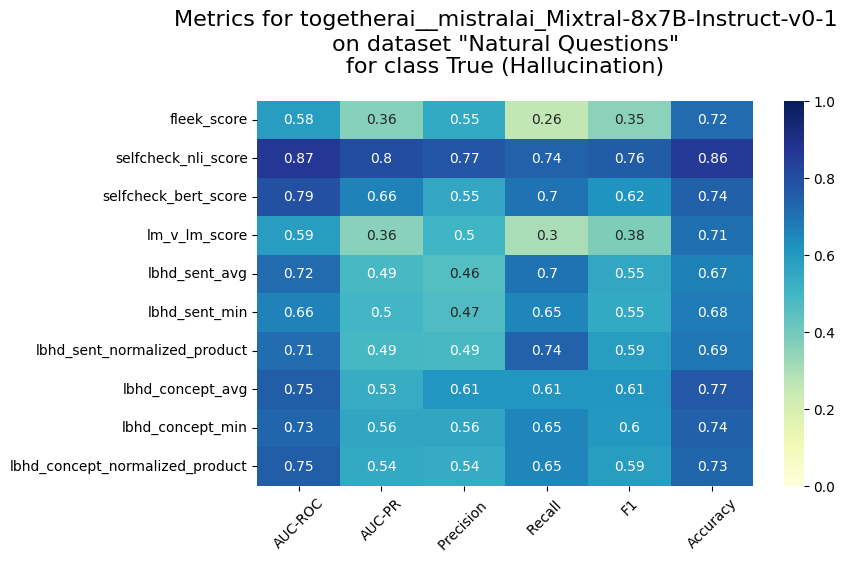

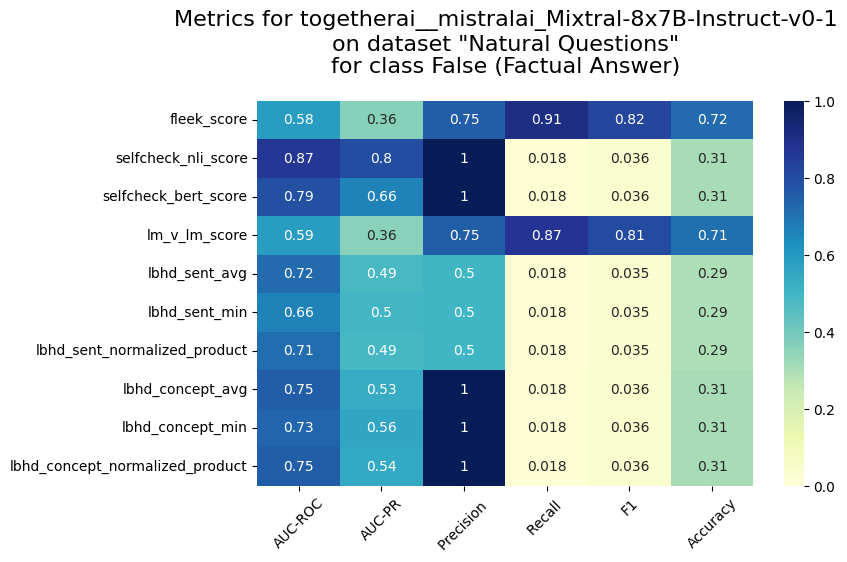

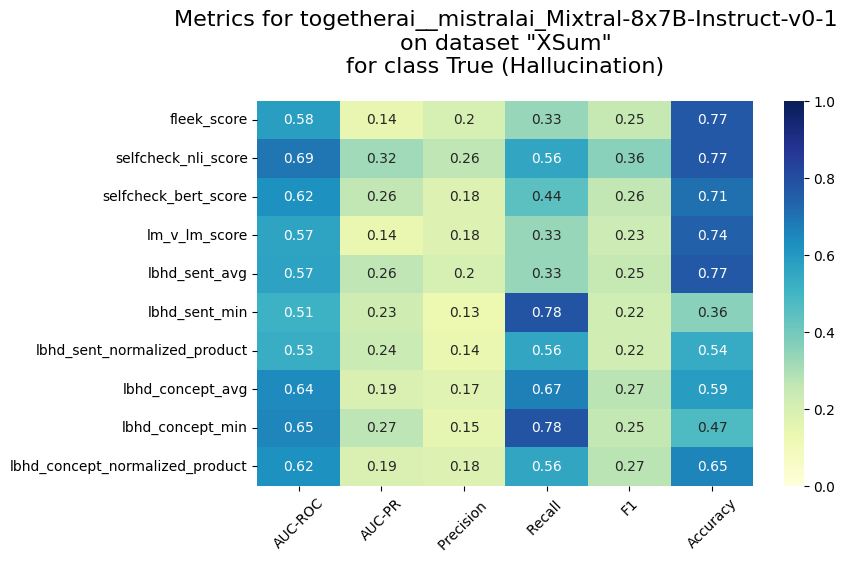

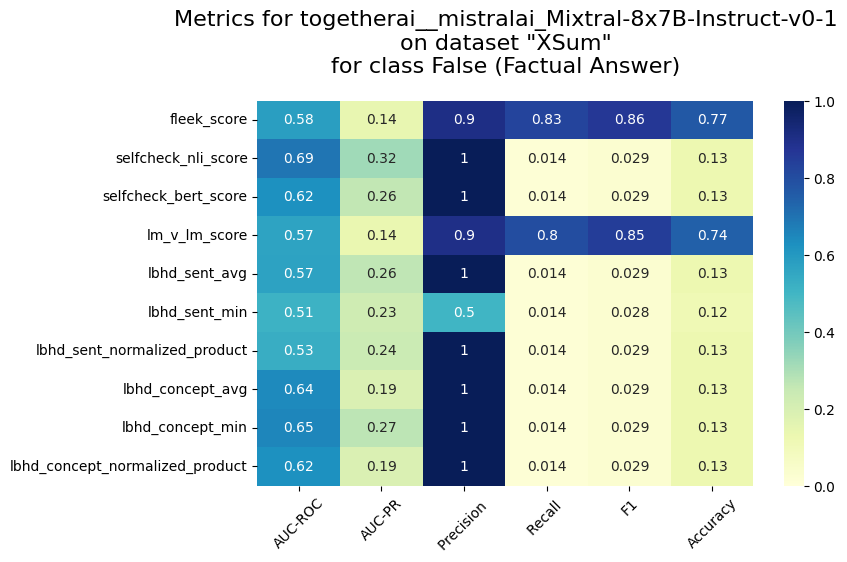

In [10]:

# Plotting metrics for each model and dataset combination
for model, datasets_metrics in all_metrics.items():
    for dataset_name, classes_metrics in datasets_metrics.items():
        for class_type, metrics in classes_metrics.items():
            plot_metrics(metrics, model, dataset_name, class_type == 'positive')

### Violin Plots

## Violin Plots and ANOVA for openai__gpt-3-5-turbo on nqopen

feature    f_value   p_value
0                      fleek_score   7.705843  0.005504
3                    lm_v_lm_score   7.705843  0.005504
1              selfcheck_nli_score  73.000000  0.444931
2             selfcheck_bert_score  73.000000  0.444931
4                    lbhd_sent_avg  73.000000  0.444931
5                    lbhd_sent_min  73.000000  0.444931
6     lbhd_sent_normalized_product  73.000000  0.444931
7                 lbhd_concept_avg  73.000000  0.444931
8                 lbhd_concept_min  73.000000  0.444931
9  lbhd_concept_normalized_product  73.000000  0.444931

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


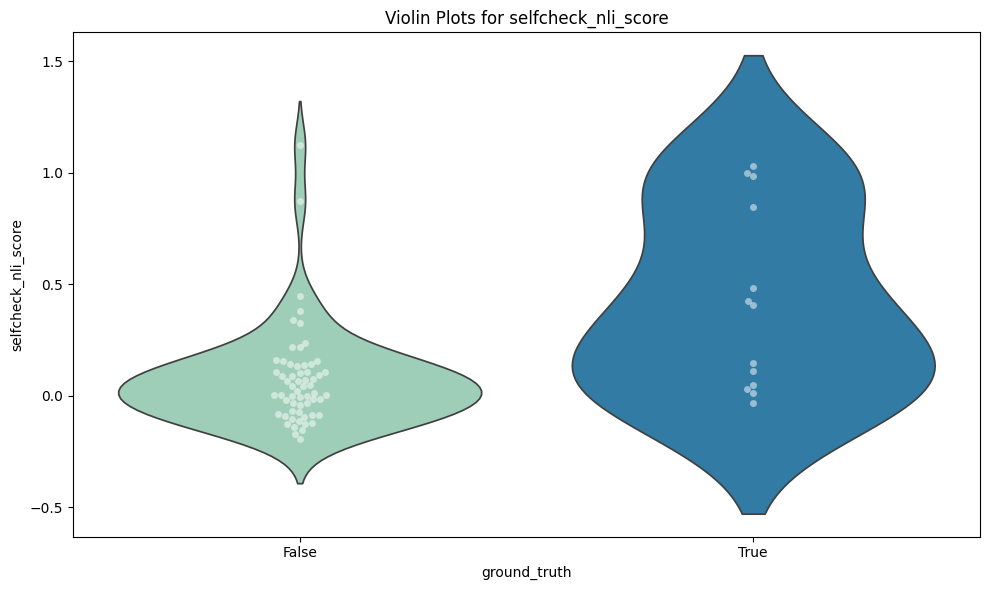

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


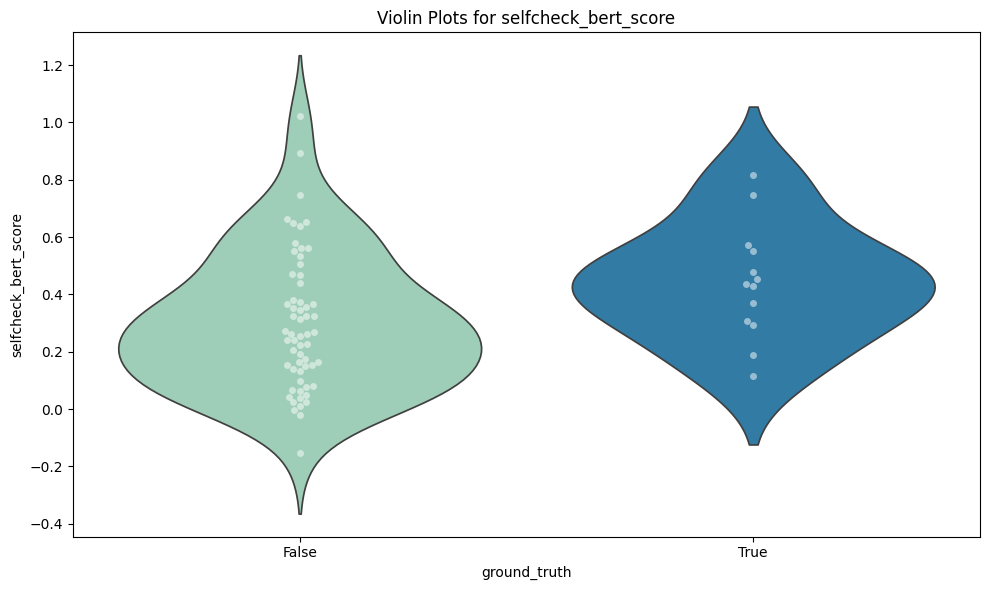

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


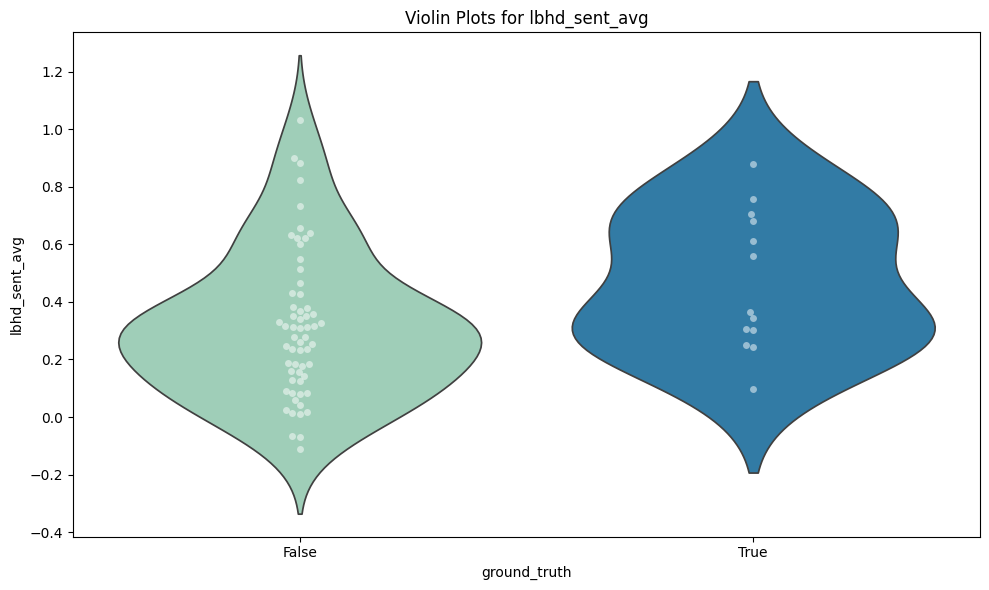

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


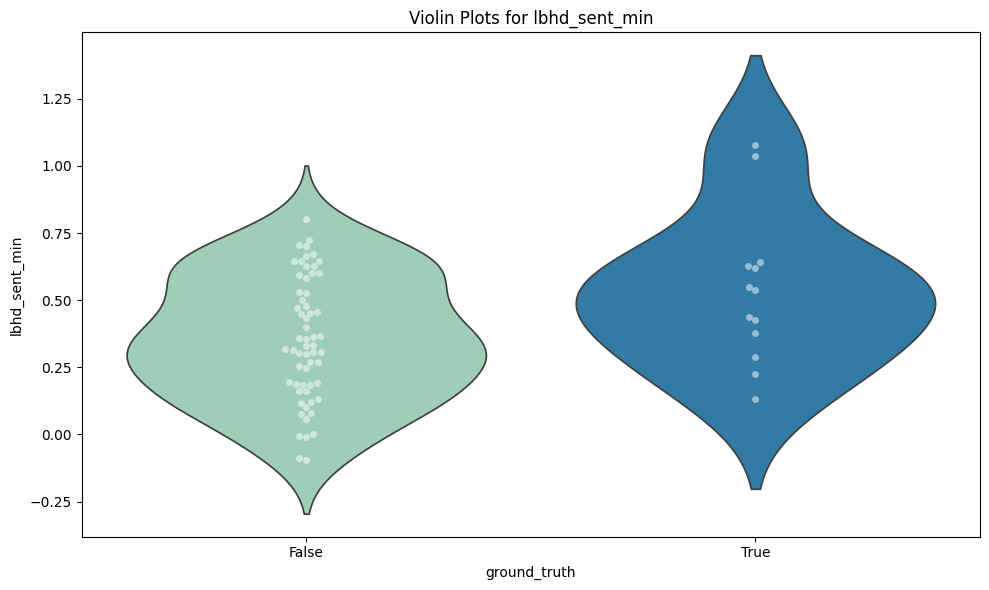

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


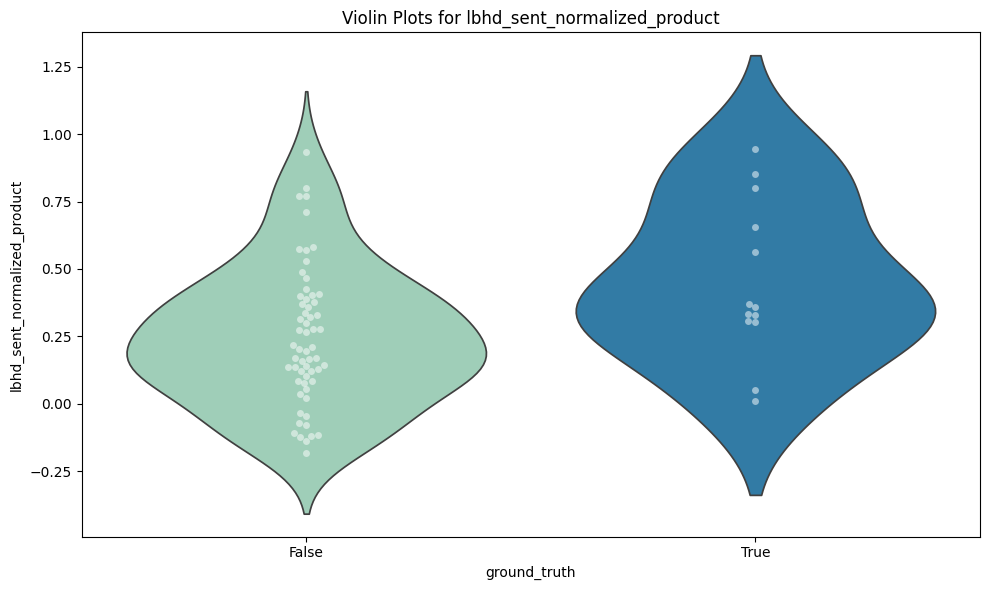

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


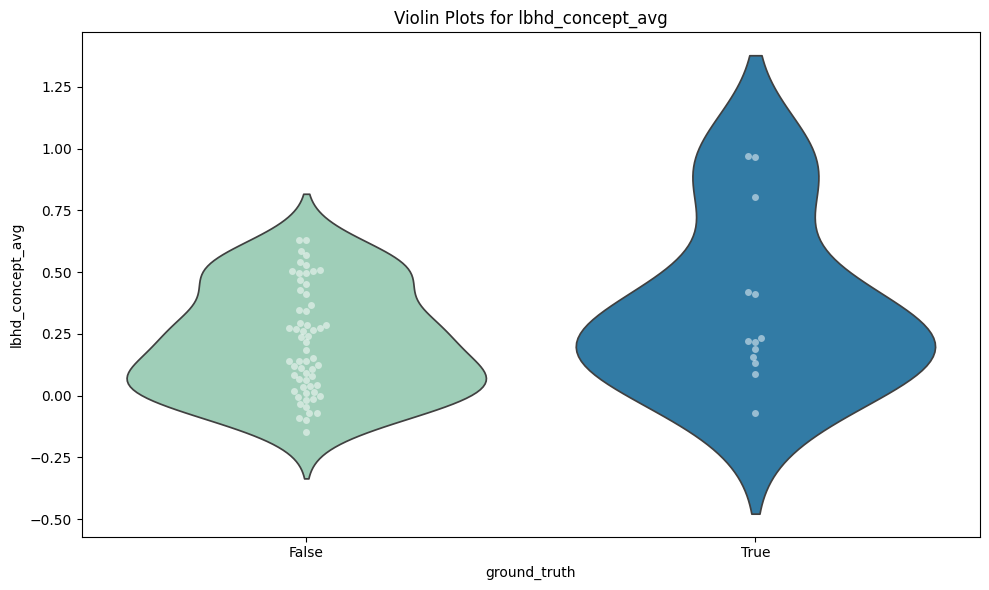

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


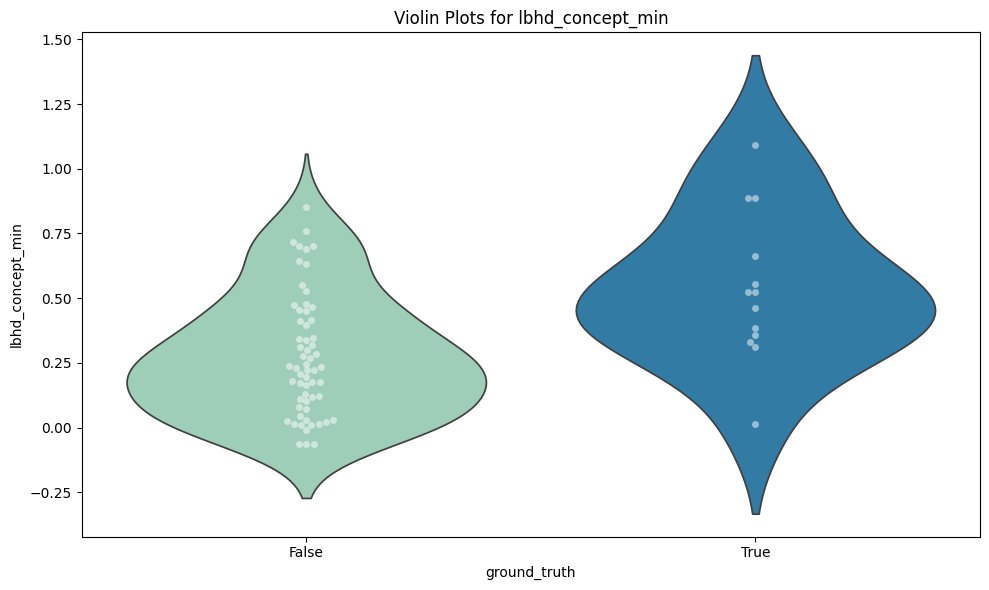

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


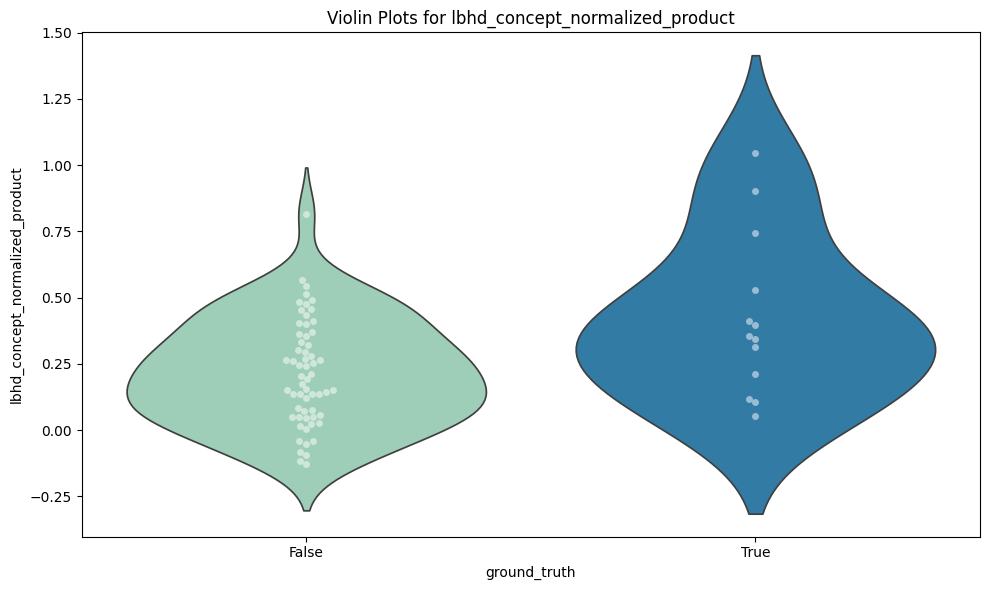

## Violin Plots and ANOVA for openai__gpt-3-5-turbo on xsum

feature  f_value   p_value
4                    lbhd_sent_avg     29.0  0.412528
6     lbhd_sent_normalized_product     29.0  0.412528
1              selfcheck_nli_score     29.0  0.412528
2             selfcheck_bert_score     29.0  0.412528
5                    lbhd_sent_min     29.0  0.412528
7                 lbhd_concept_avg     29.0  0.412528
8                 lbhd_concept_min     29.0  0.412528
9  lbhd_concept_normalized_product     29.0  0.412528
0                      fleek_score      0.0  1.000000
3                    lm_v_lm_score      0.0  1.000000

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


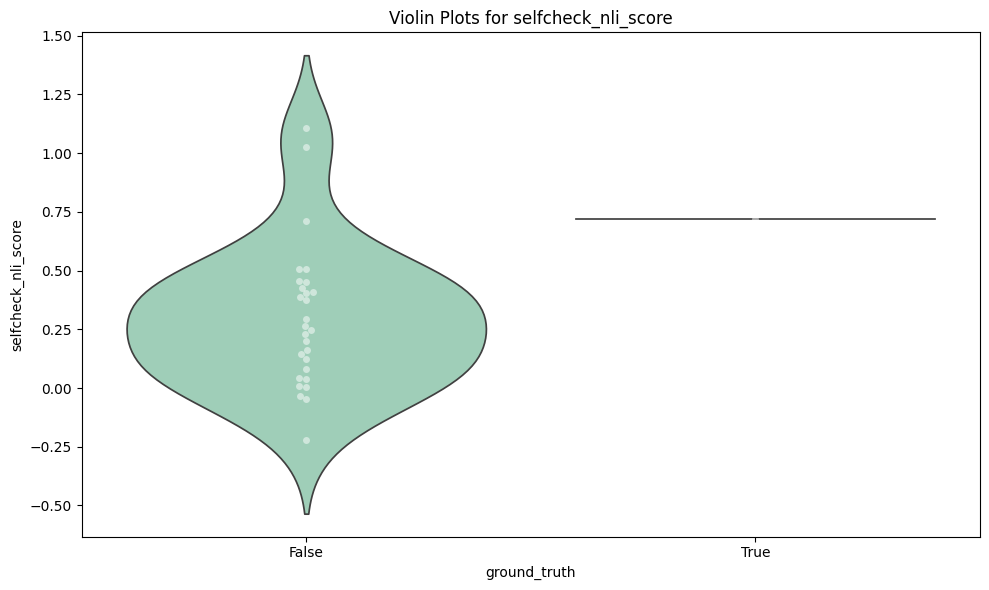

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


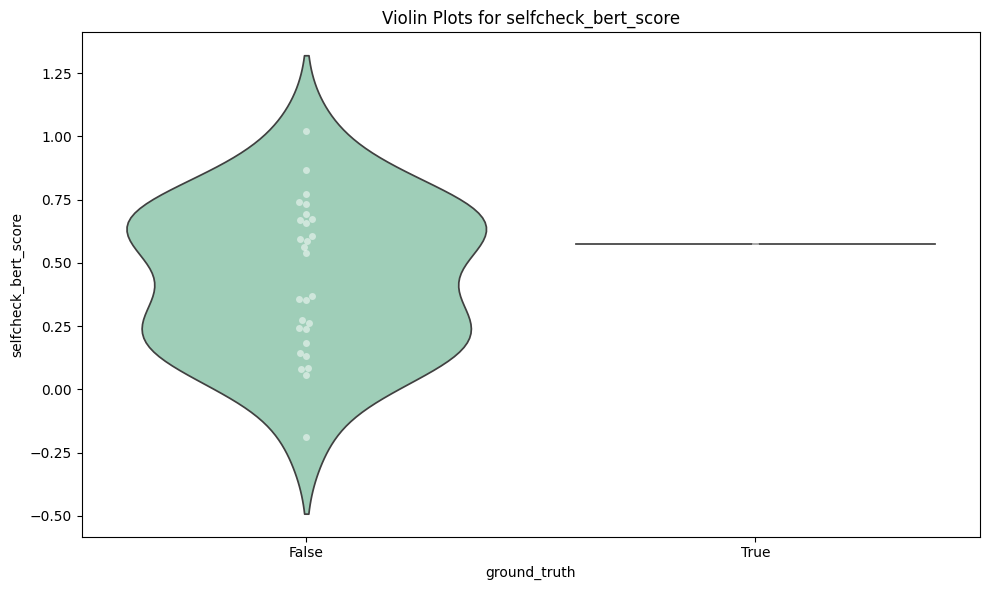

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


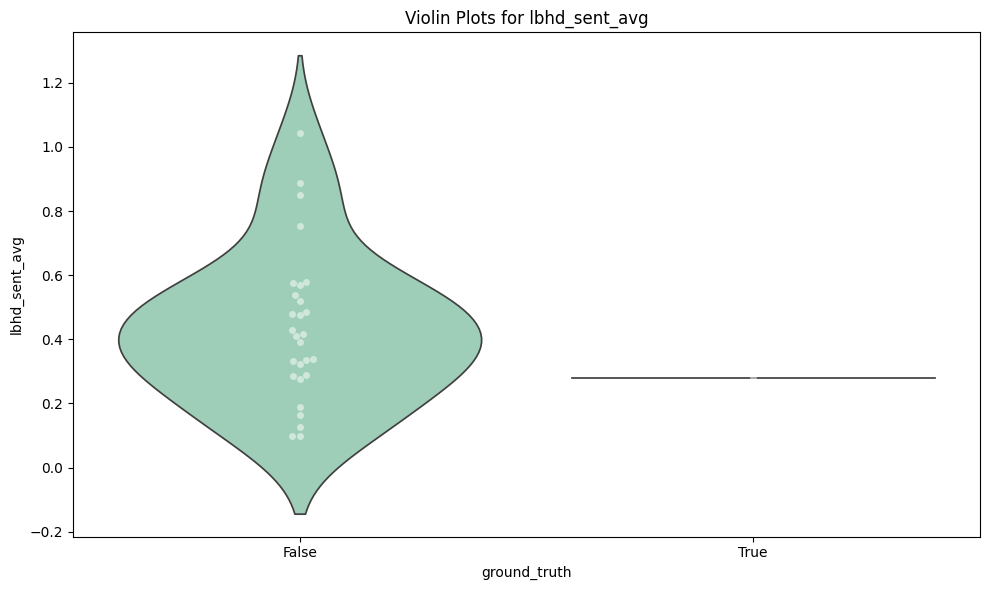

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


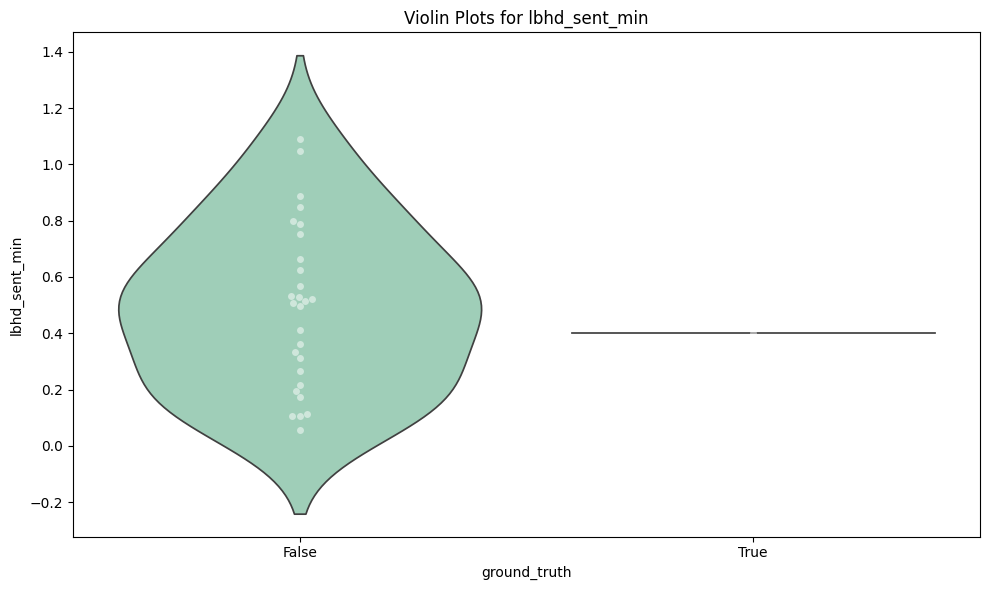

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


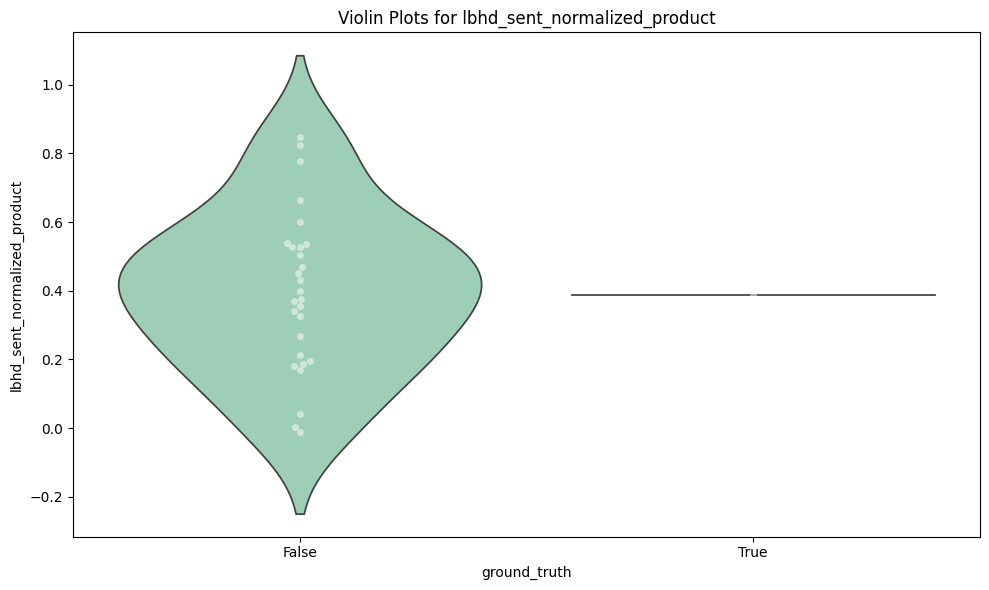

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


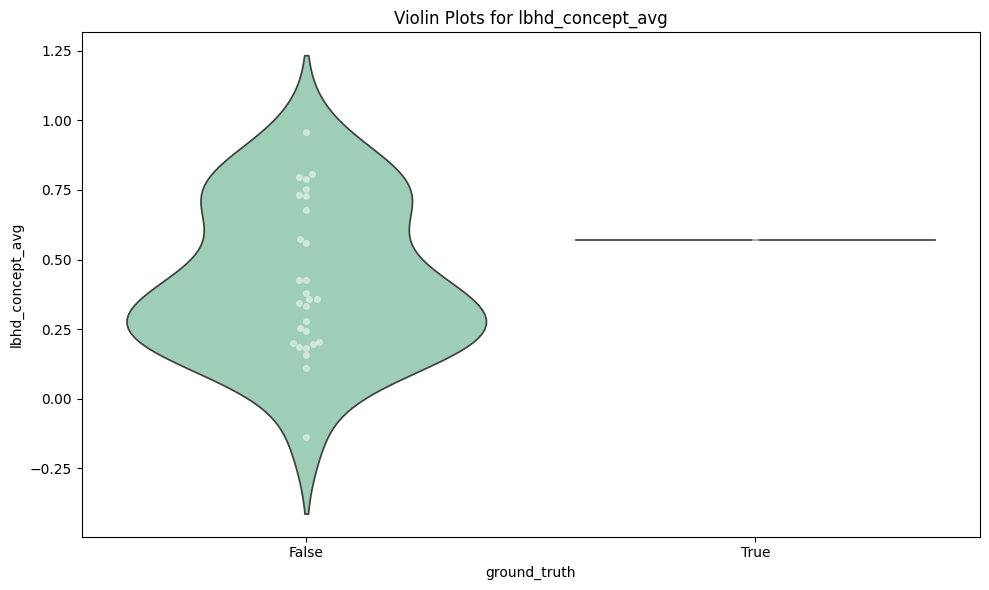

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


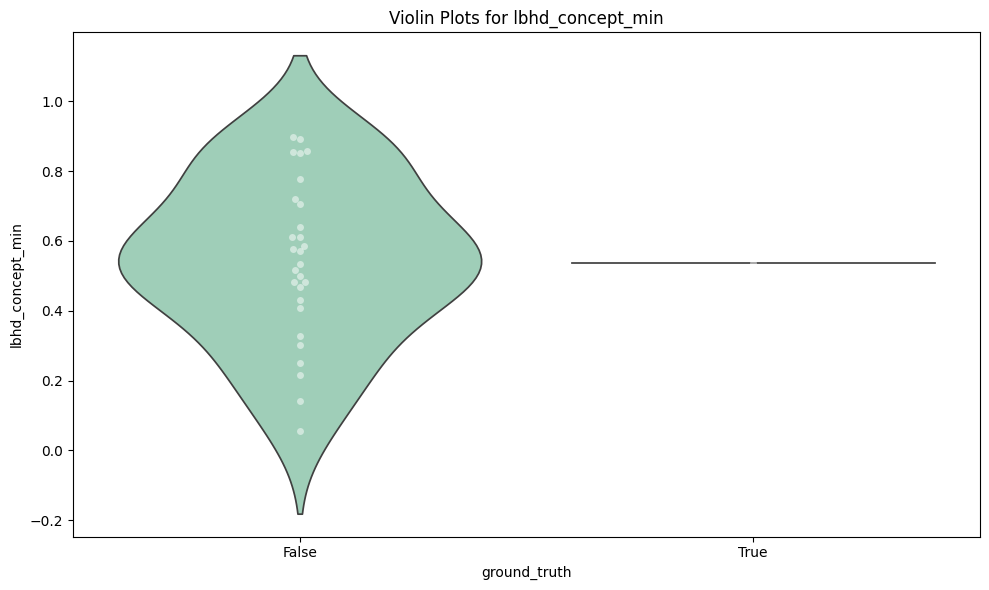

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


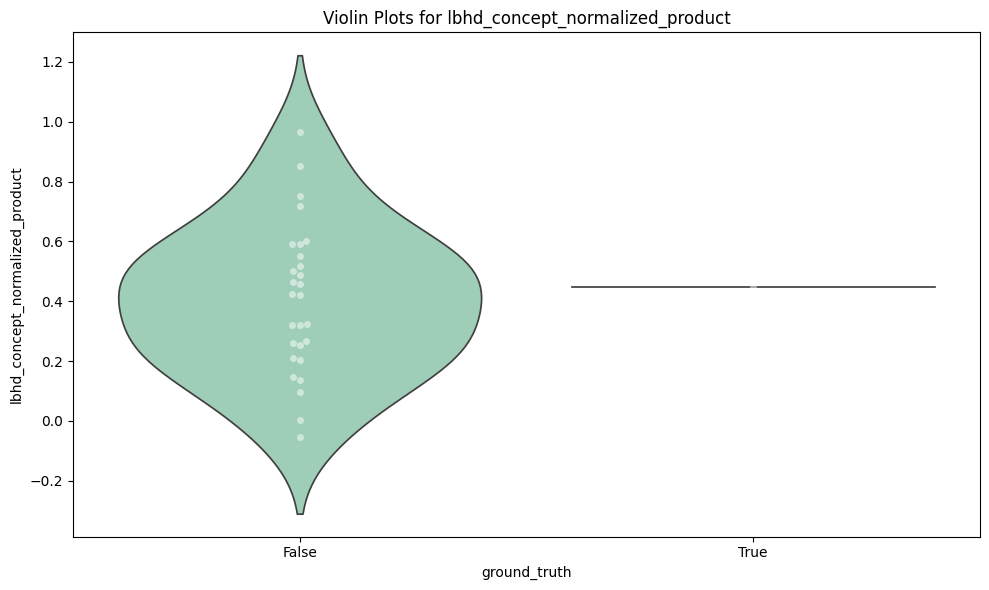

## Violin Plots and ANOVA for togetherai_2__mistralai_Mistral-7B-Instruct-v0-1 on nqopen

feature    f_value   p_value
3                    lm_v_lm_score   1.019395  0.312663
5                    lbhd_sent_min  80.000000  0.385044
8                 lbhd_concept_min  80.000000  0.385044
0              selfcheck_nli_score  80.000000  0.447399
4                    lbhd_sent_avg  80.000000  0.447399
6     lbhd_sent_normalized_product  80.000000  0.447399
7                 lbhd_concept_avg  80.000000  0.447399
9  lbhd_concept_normalized_product  80.000000  0.447399
1             selfcheck_bert_score  77.492163  0.494938
2                      fleek_score   0.000000  1.000000

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


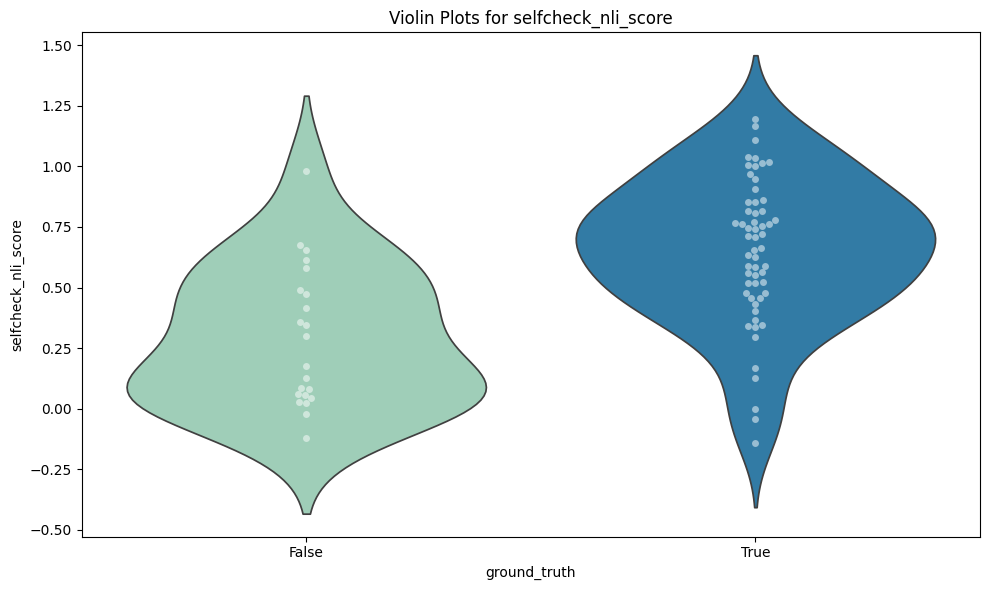

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


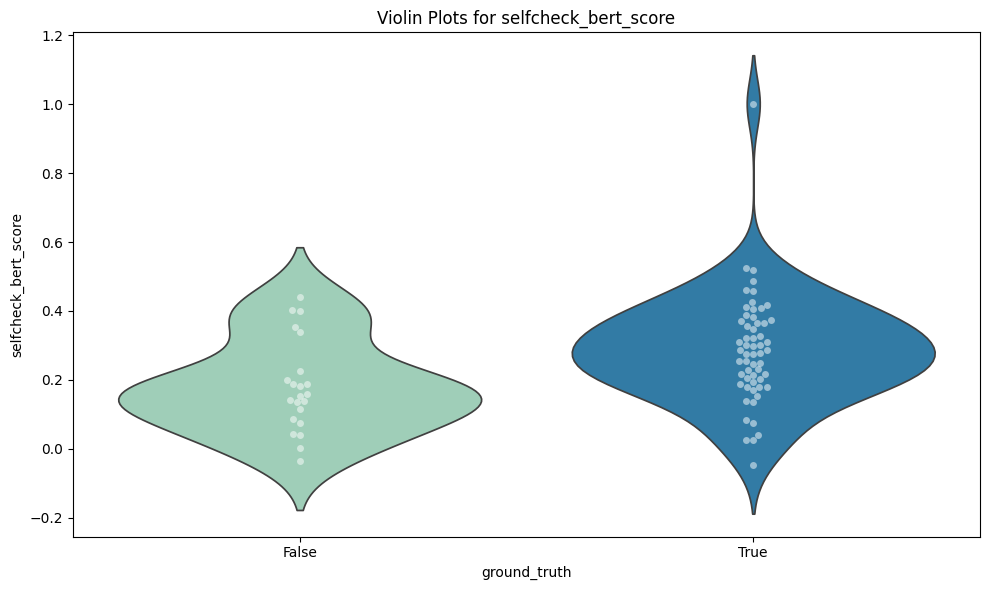

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


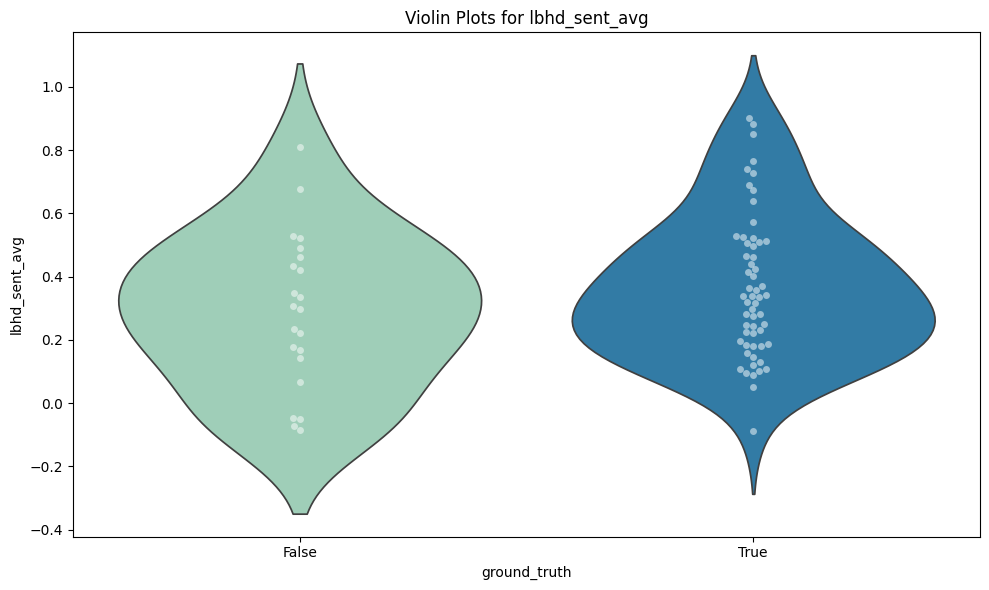

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


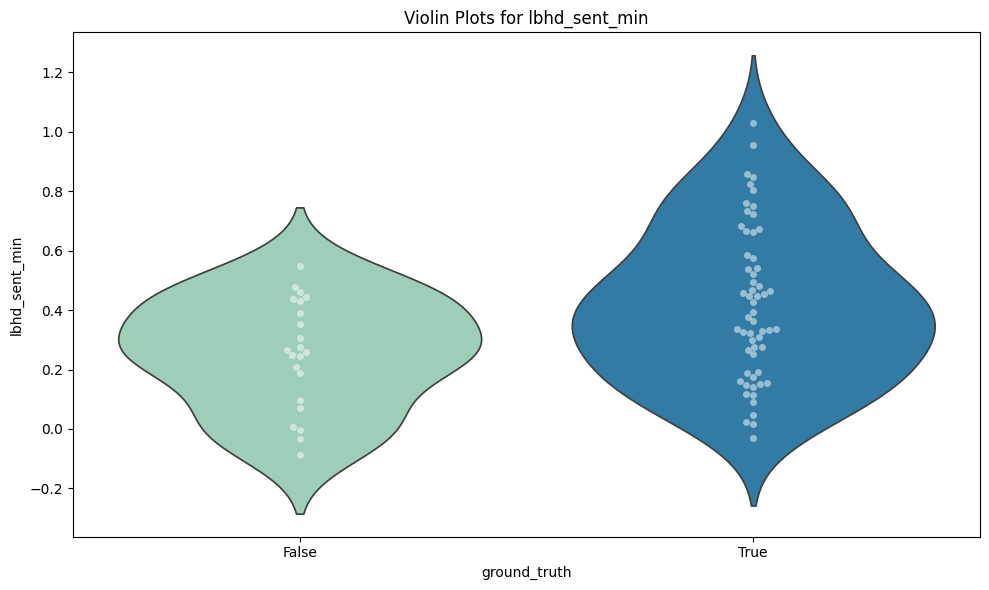

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


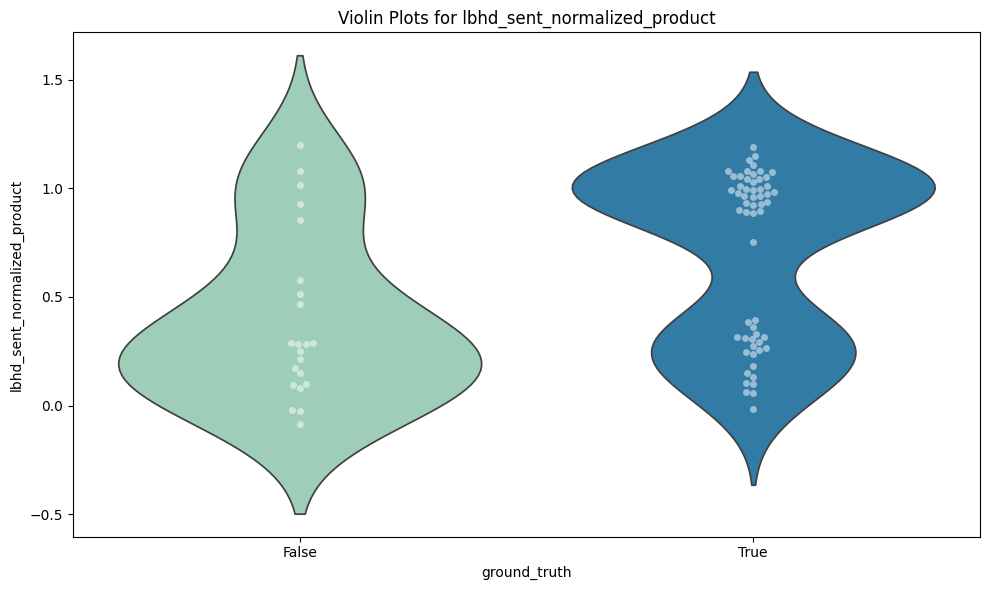

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


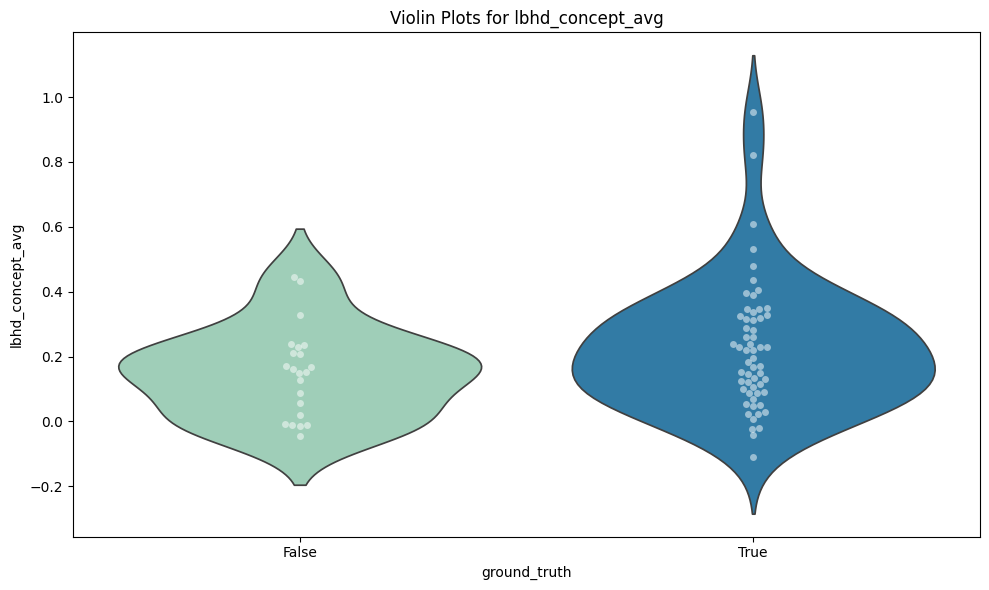

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


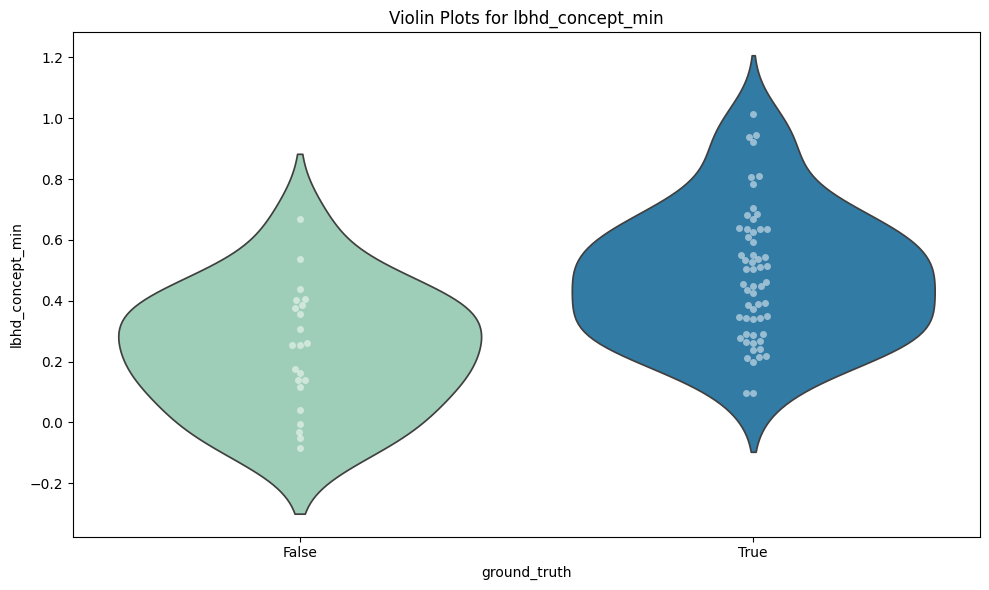

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


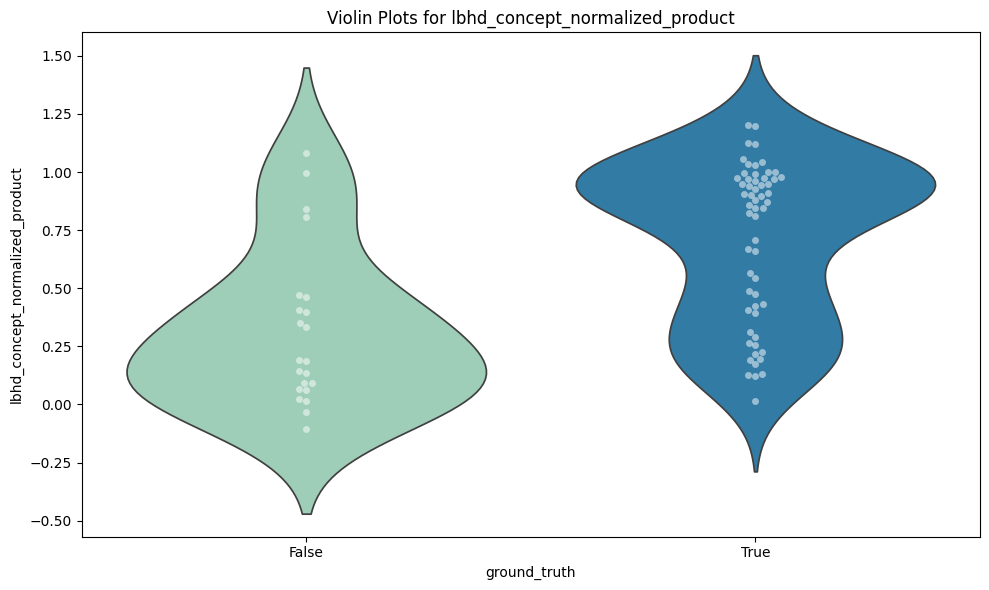

## Violin Plots and ANOVA for togetherai_2__mistralai_Mistral-7B-Instruct-v0-1 on xsum

feature    f_value   p_value
5                    lbhd_sent_min  80.000000  0.416024
8                 lbhd_concept_min  80.000000  0.416024
6     lbhd_sent_normalized_product  80.000000  0.447399
0              selfcheck_nli_score  80.000000  0.447399
1             selfcheck_bert_score  80.000000  0.447399
4                    lbhd_sent_avg  80.000000  0.447399
7                 lbhd_concept_avg  80.000000  0.447399
9  lbhd_concept_normalized_product  80.000000  0.447399
3                    lm_v_lm_score   0.561057  0.453835
2                      fleek_score   0.062036  0.803306

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


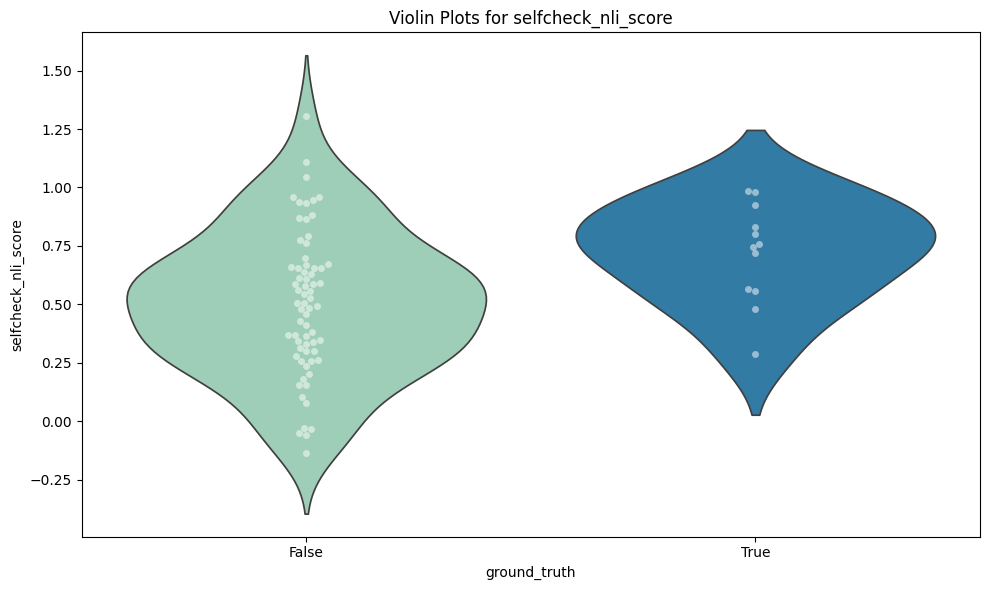

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


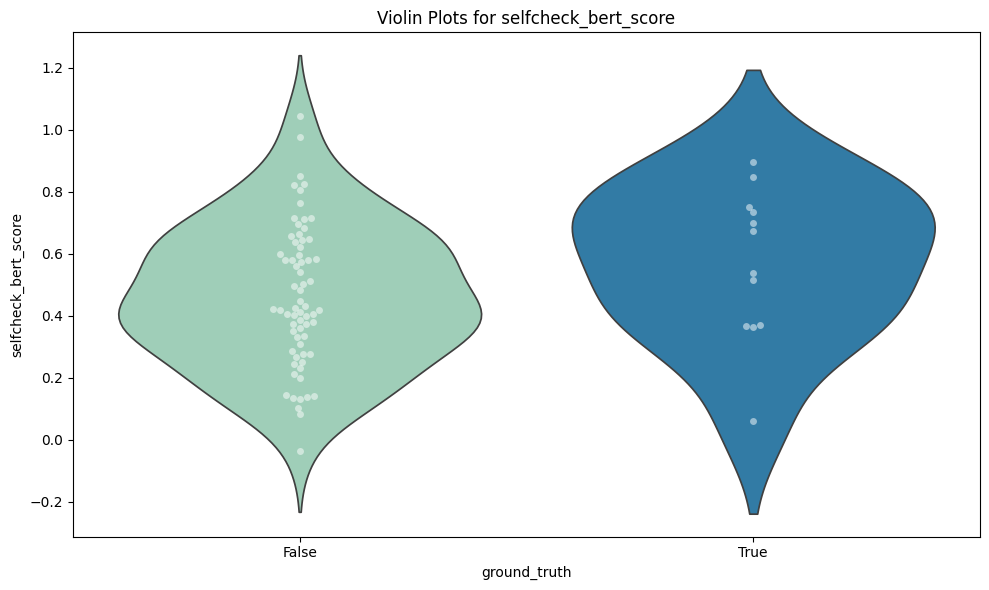

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


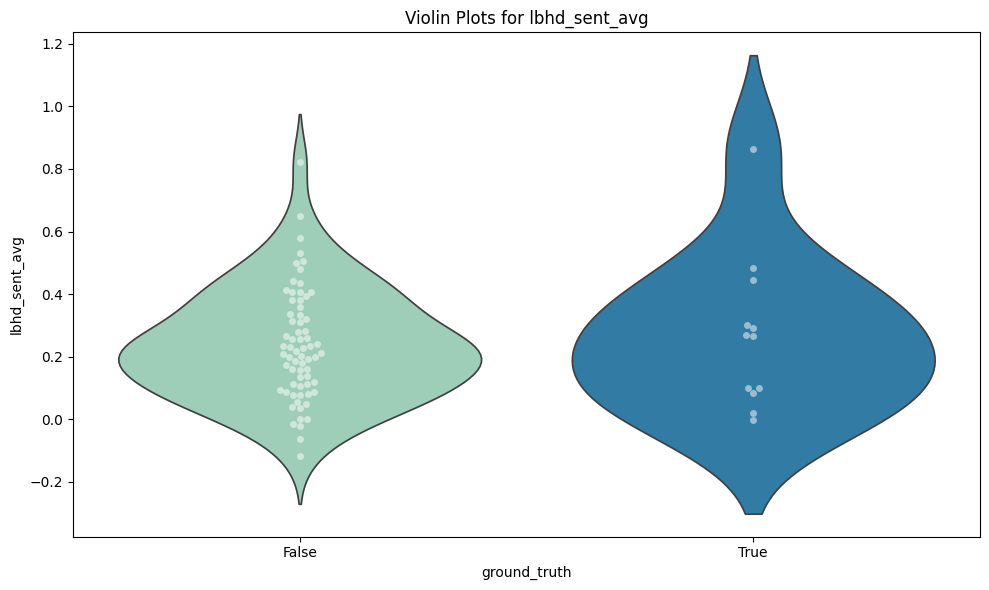

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


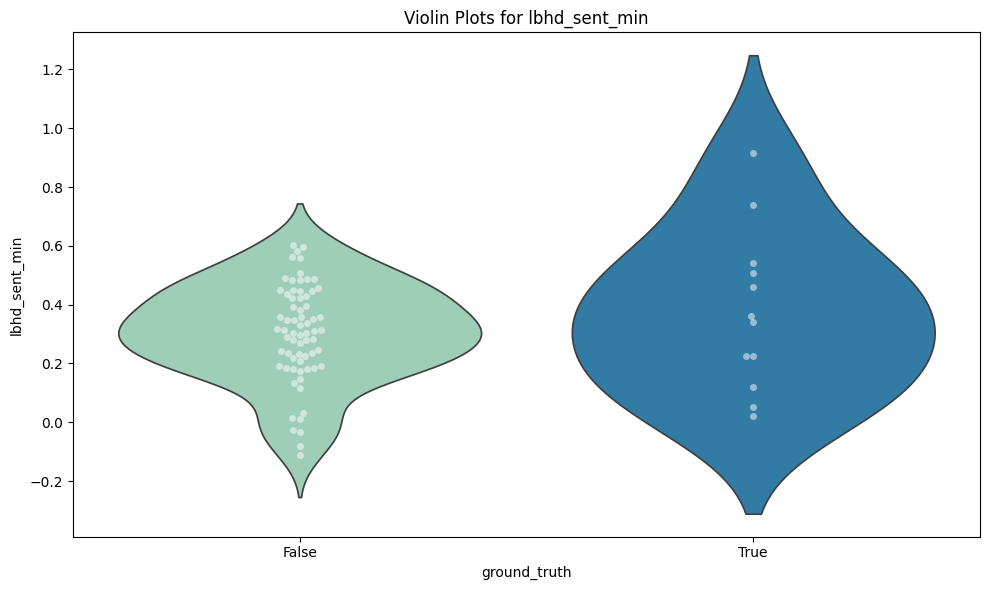

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


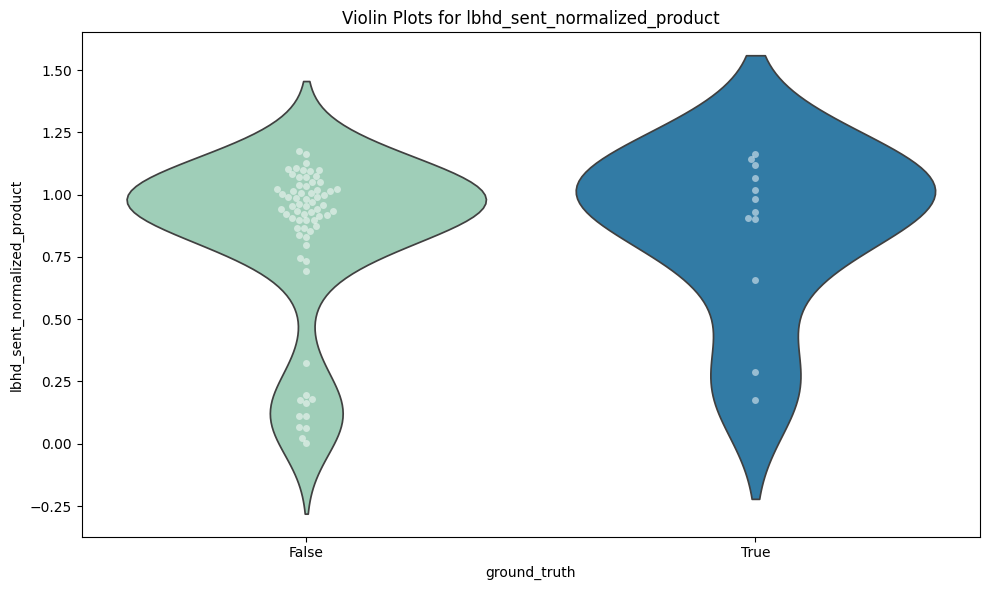

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


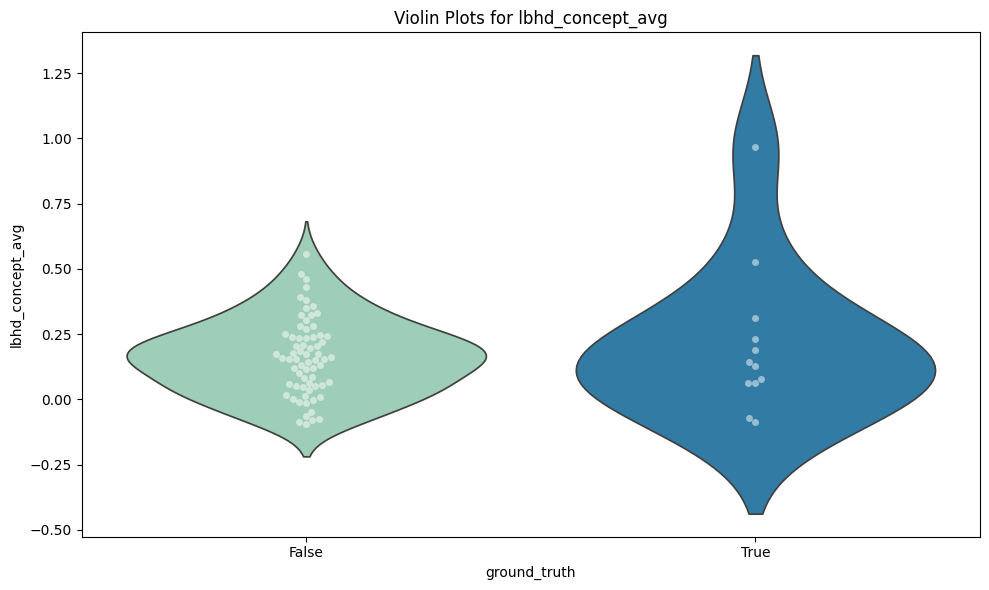

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


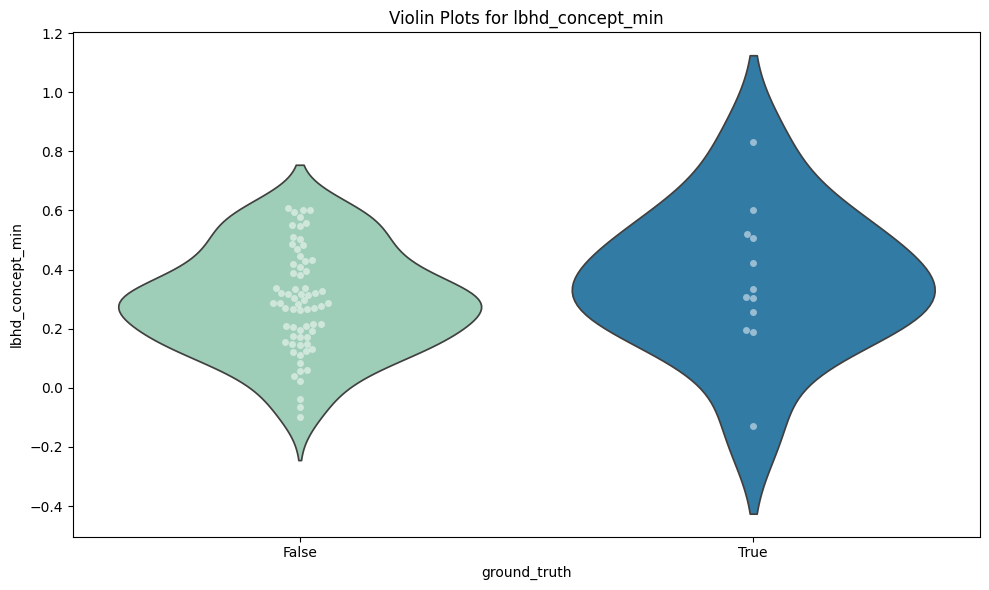

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


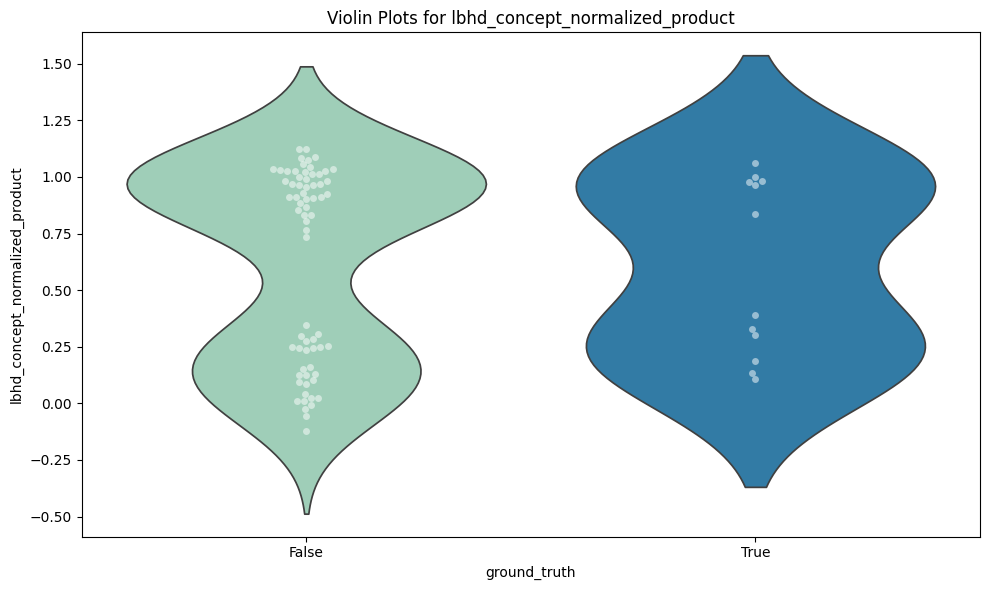

## Violin Plots and ANOVA for togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1 on nqopen

feature    f_value   p_value
0                      fleek_score   2.591564  0.107434
3                    lm_v_lm_score   2.355264  0.124861
2             selfcheck_bert_score  78.000000  0.446728
9  lbhd_concept_normalized_product  78.000000  0.446728
1              selfcheck_nli_score  78.000000  0.446728
4                    lbhd_sent_avg  78.000000  0.446728
5                    lbhd_sent_min  78.000000  0.446728
6     lbhd_sent_normalized_product  78.000000  0.446728
7                 lbhd_concept_avg  78.000000  0.446728
8                 lbhd_concept_min  78.000000  0.446728

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


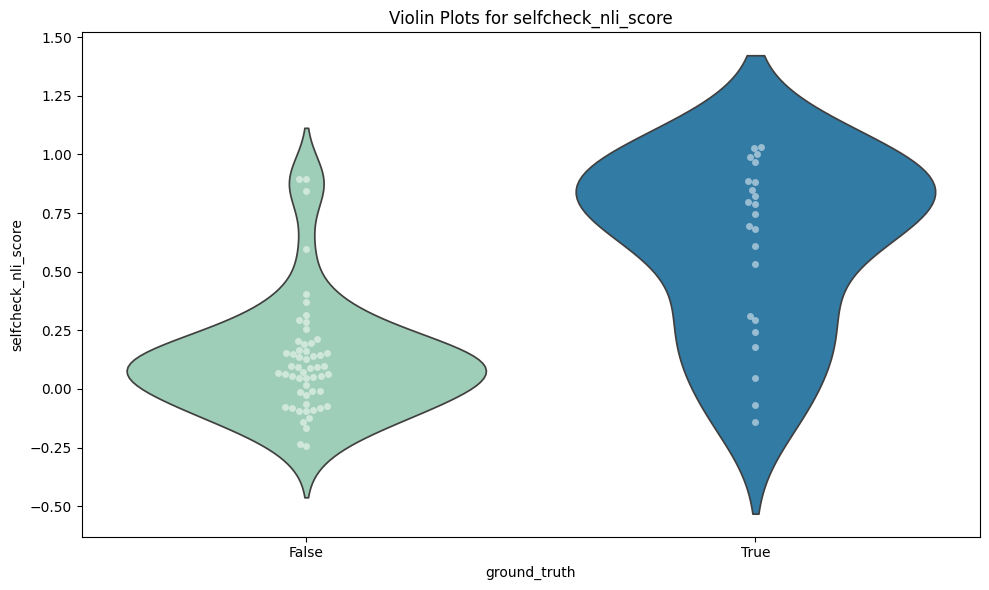

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


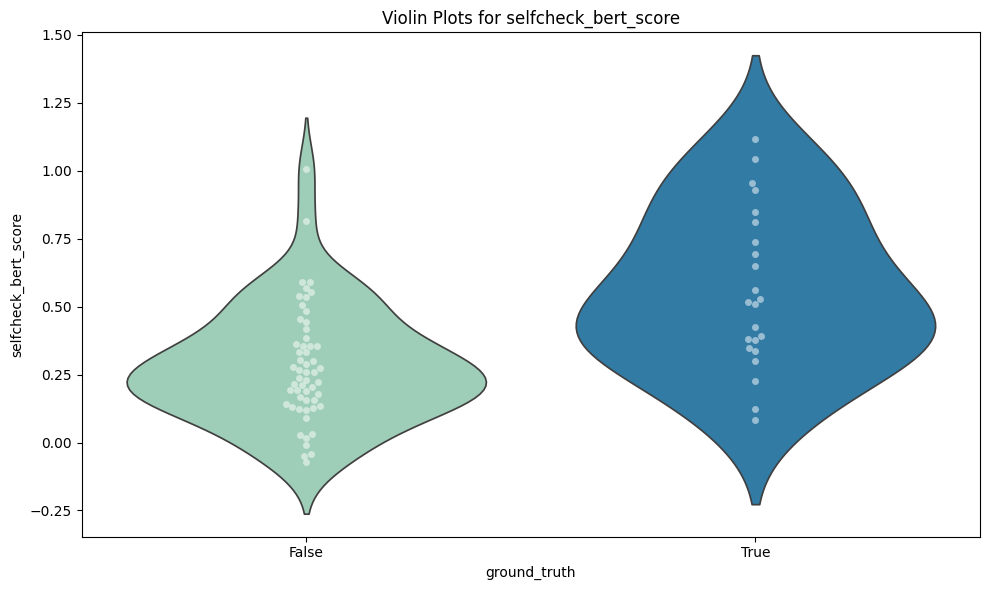

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


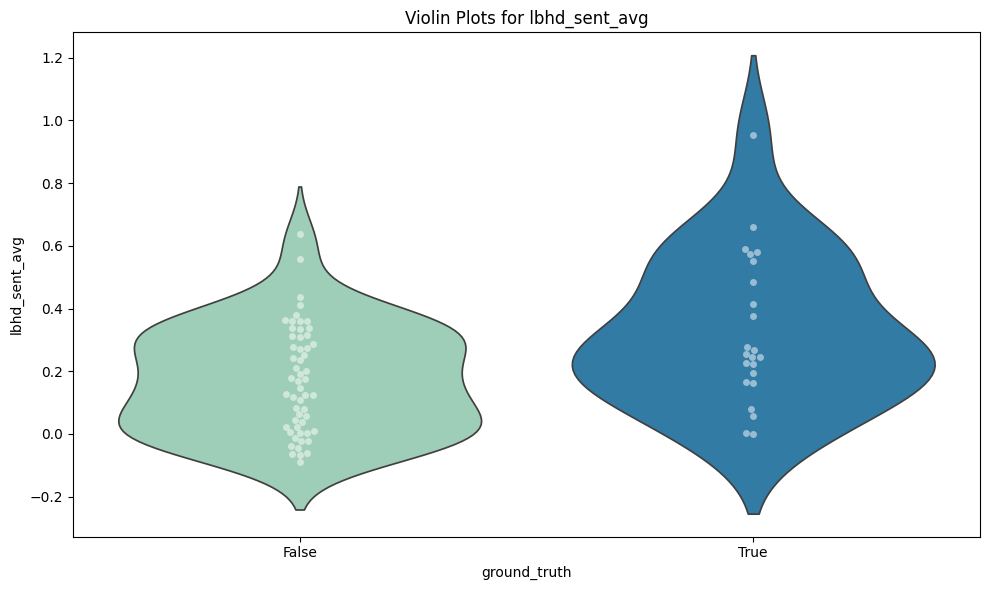

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


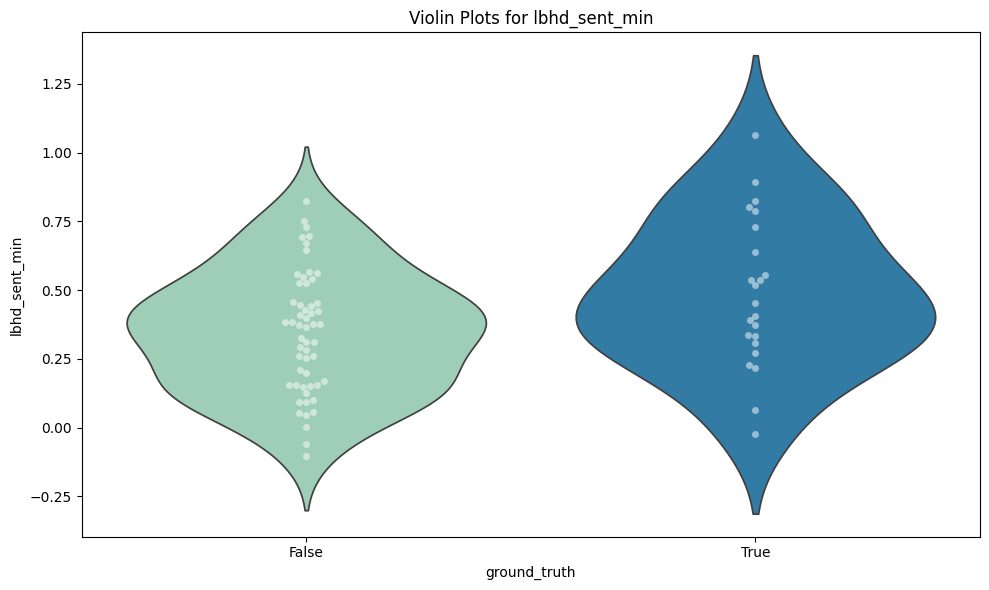

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


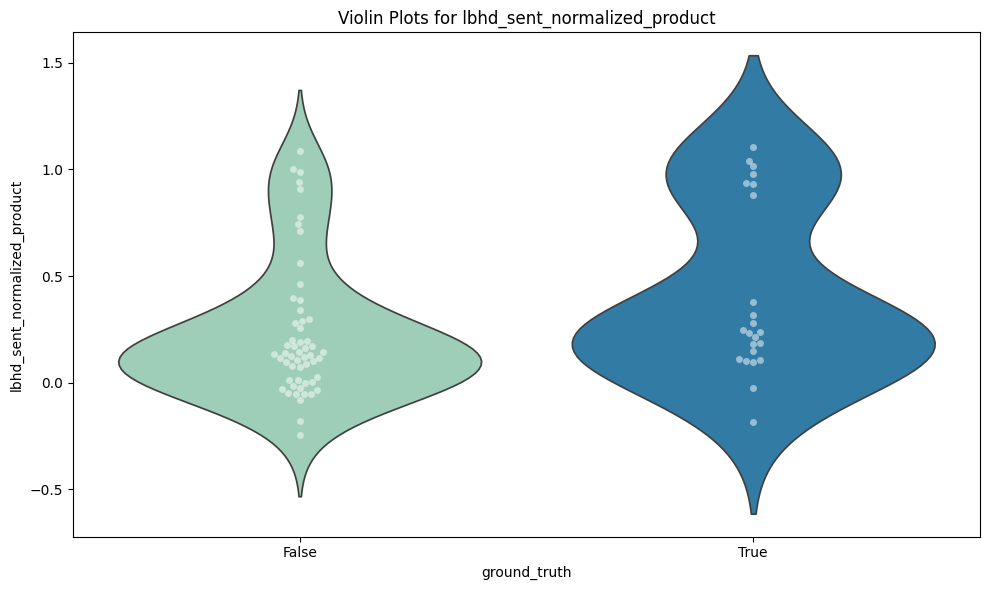

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


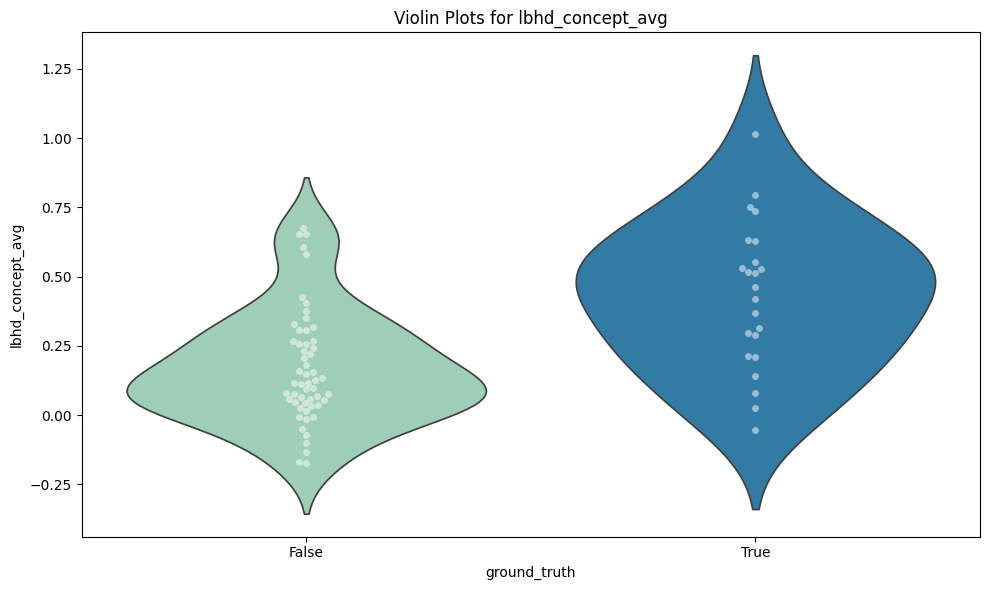

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


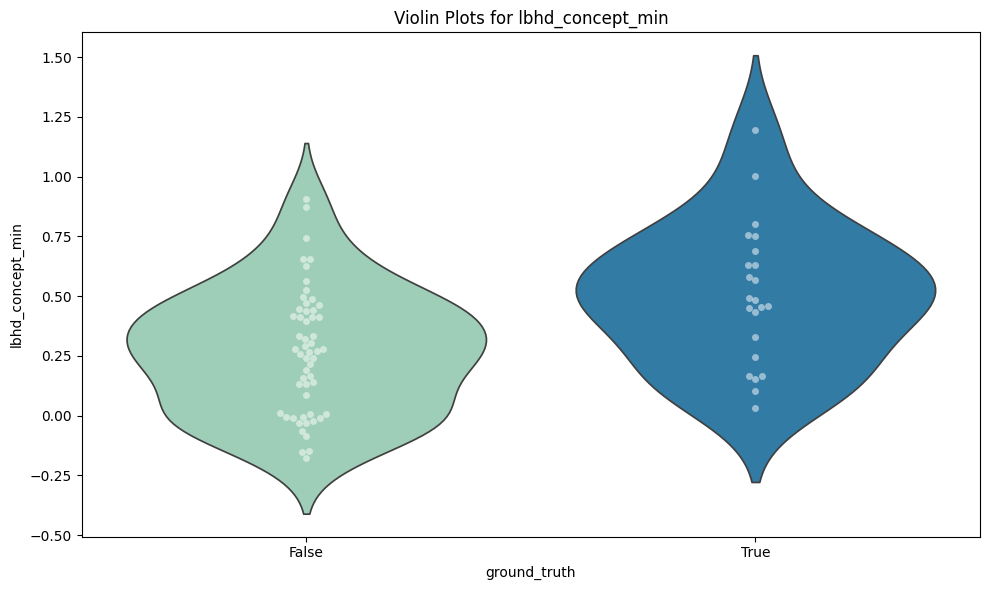

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


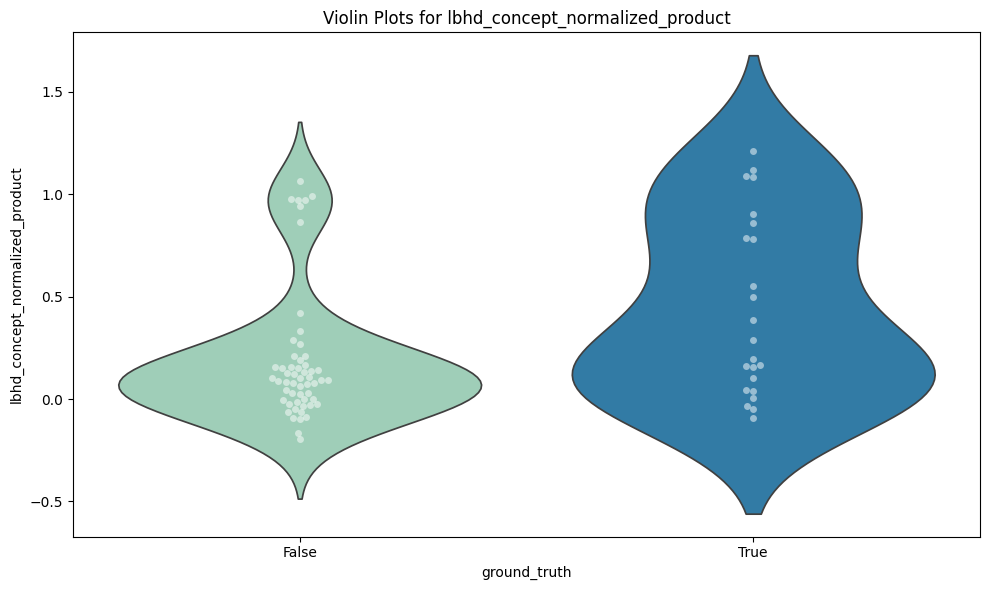

## Violin Plots and ANOVA for togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1 on xsum

feature    f_value   p_value
8                 lbhd_concept_min  78.000000  0.383597
1              selfcheck_nli_score  78.000000  0.446728
7                 lbhd_concept_avg  78.000000  0.446728
2             selfcheck_bert_score  78.000000  0.446728
4                    lbhd_sent_avg  78.000000  0.446728
6     lbhd_sent_normalized_product  78.000000  0.446728
9  lbhd_concept_normalized_product  78.000000  0.446728
0                      fleek_score   0.478491  0.489107
5                    lbhd_sent_min  73.101449  0.507688
3                    lm_v_lm_score   0.213660  0.643914

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


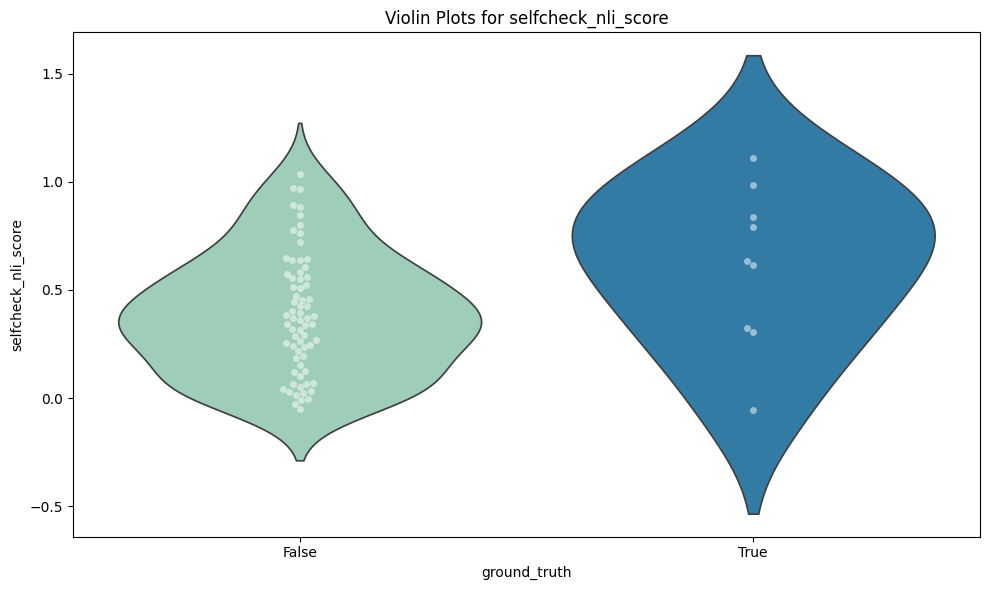

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


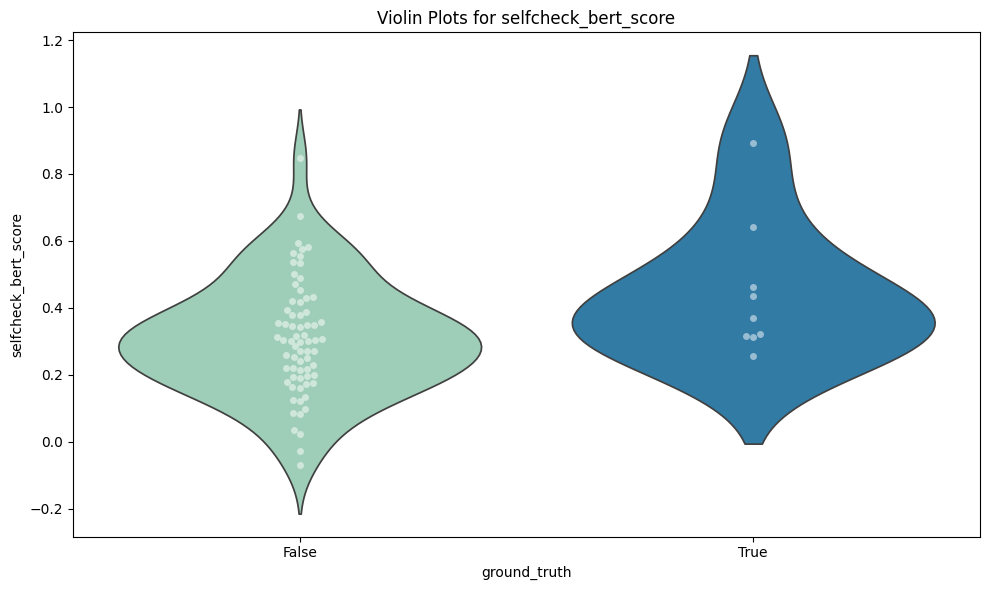

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


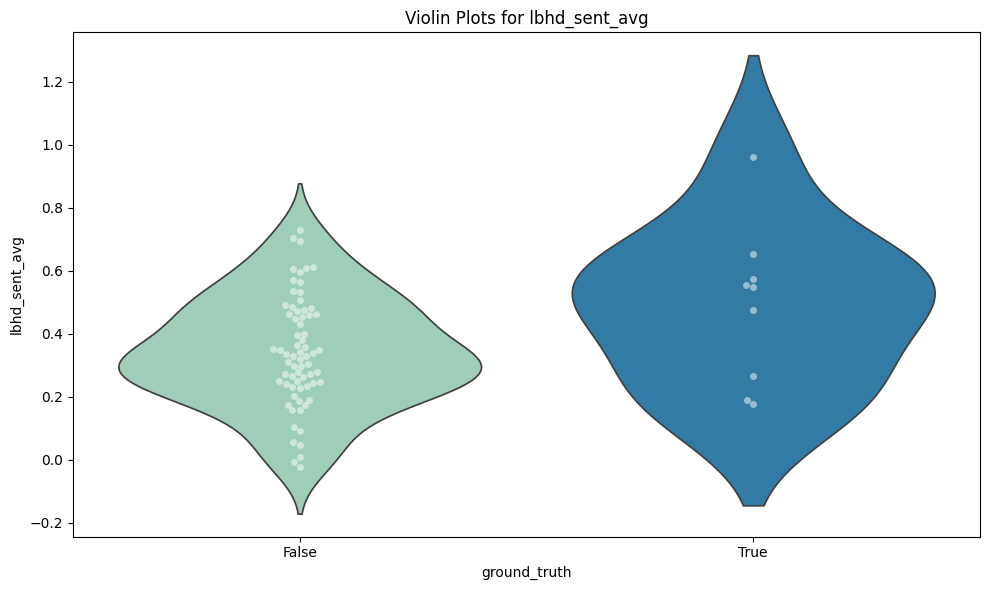

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


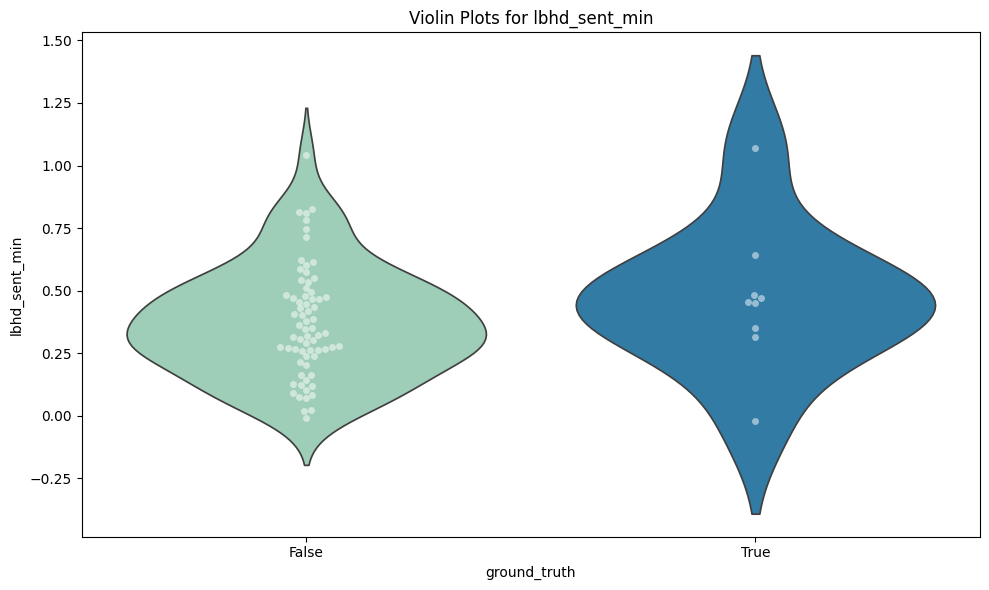

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


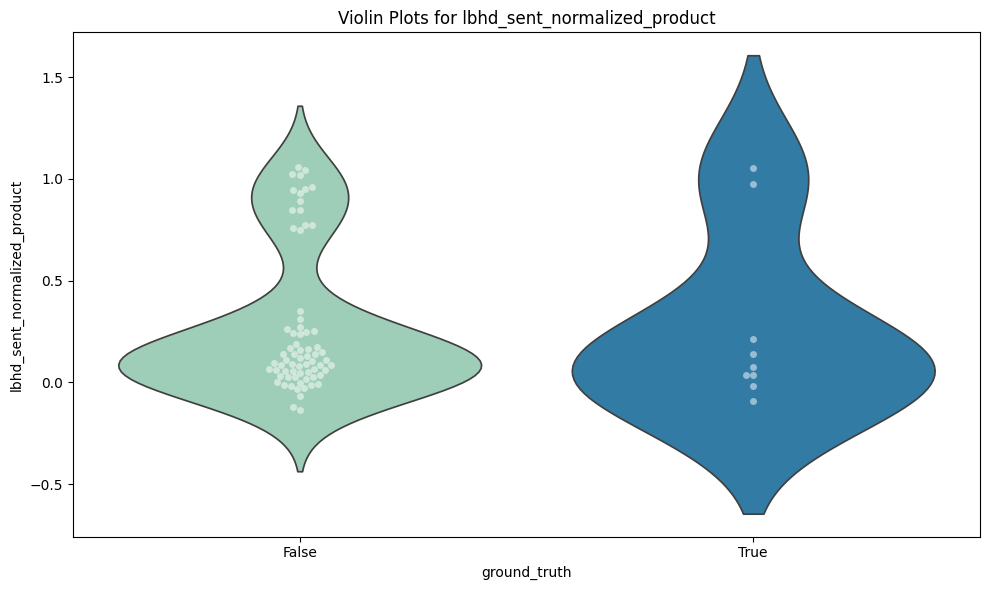

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


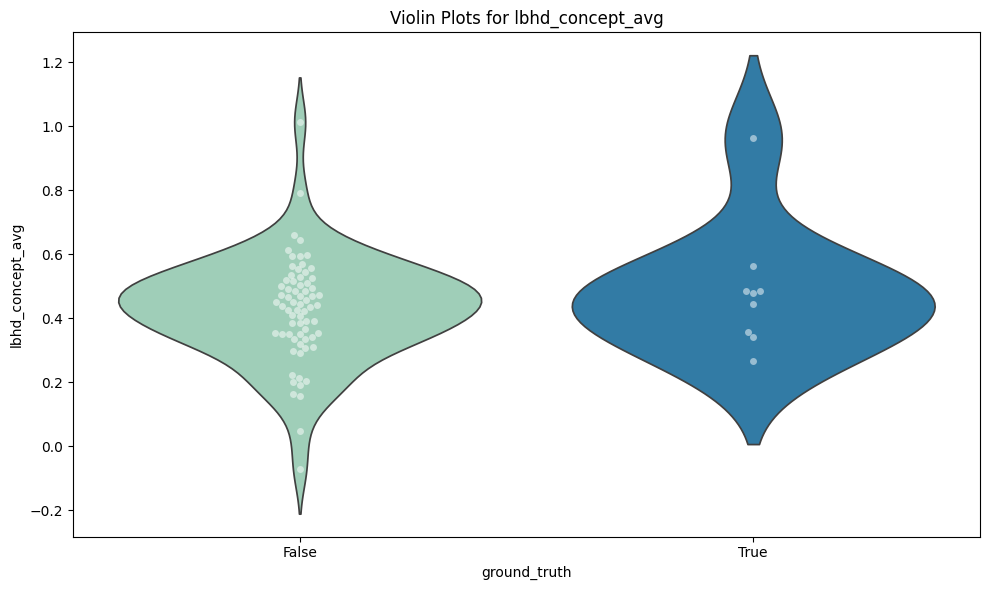

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


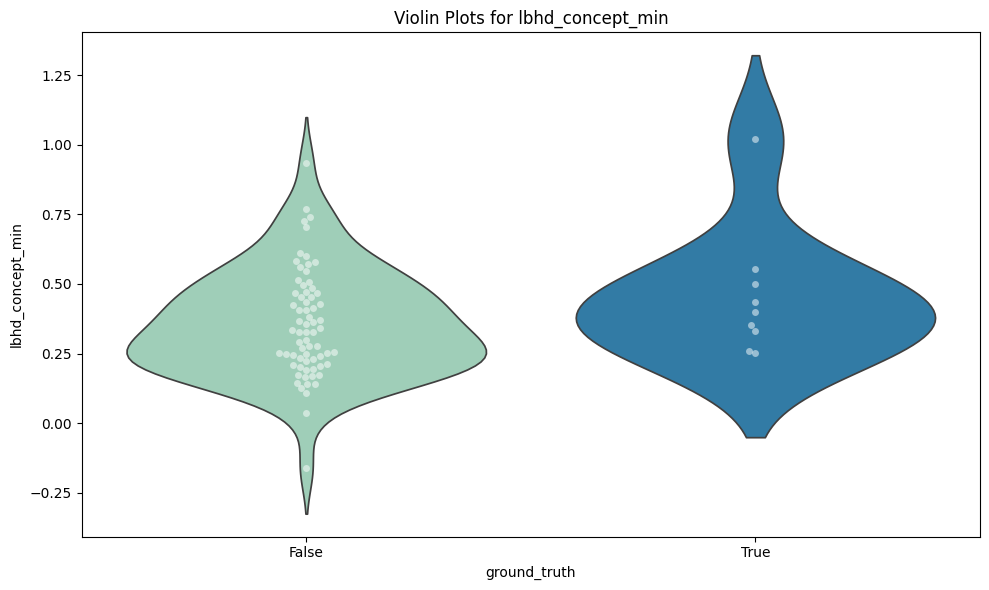

C:\Users\sbene\AppData\Local\Temp\ipykernel_8480\479095841.py:298: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=df['ground_truth'], y=df[col], inner=None, ax=ax, palette='YlGnBu')


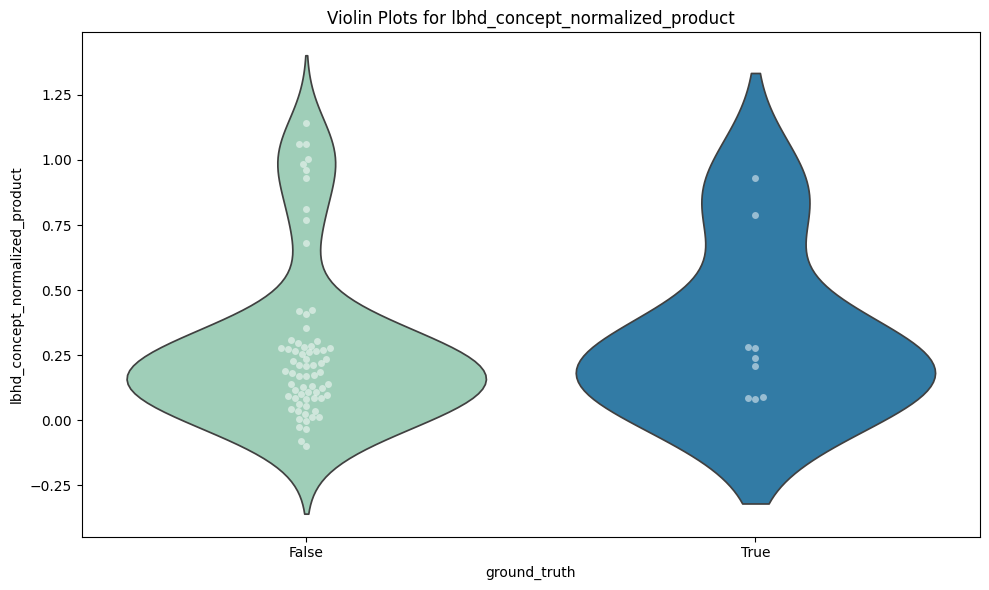

In [11]:
# Plotting violin plots and ANOVA for each model and dataset combination
for model_name, dataset_name, processed_df in all_processed_dfs:
    display(Markdown(f"## Violin Plots and ANOVA for {model_name} on {dataset_name}"))
    violin_plots_and_anova(processed_df)